## **Richter's Predictor: Modeling Earthquake Damage.**

<img src="https://s3.amazonaws.com/drivendata-public-assets/nepal-quake-bm-2.JPG" width="500">

## **Importamos la librerías necesarias**

In [ ]:
!pip install lazypredict

In [ ]:
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.stats.mstats import winsorize
from matplotlib.colors import ListedColormap
import sklearn.neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.utils.multiclass import unique_labels

import lazypredict
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
import sklearn.externals
import joblib

## **Importamos los datos**

In [ ]:
df_submission= pd.read_csv("https://raw.githubusercontent.com/carolProg/SNS_23_24/main/ACT_3_7_TERREMOTO/submission_format.csv")
train_labels = pd.read_csv("https://raw.githubusercontent.com/carolProg/SNS_23_24/main/ACT_3_7_TERREMOTO/train_labels.csv")
train_values = pd.read_csv("https://raw.githubusercontent.com/carolProg/SNS_23_24/main/ACT_3_7_TERREMOTO/train_values.csv")
test_values = pd.read_csv("https://raw.githubusercontent.com/carolProg/SNS_23_24/main/ACT_3_7_TERREMOTO/test_values.csv")

# **Análisis de Datos**


* Comprobar valores nulos y NaN
* Conocer el tipo de dato de cada variable
* Observar la distribución de los datos
* Identificar los outliers
* Comprobar valores duplicados


In [ ]:
print("# Train Values: {}".format(train_values.shape))
print("# Train Labels: {}".format(train_labels.shape))
print("# Test Values: {}".format(test_values.shape))

# Train Values: (260601, 39)
# Train Labels: (260601, 2)
# Test Values: (86868, 39)


In [ ]:
train_labels.head()

building_id  damage_grade
0       802906             3
1        28830             2
2        94947             3
3       590882             2
4       201944             3

La etiqueta de entrenamiento consiste en la identificación de cada edificio y su grado de daño (1,2,3), por lo que combinamos las etiquetas con los datos de entrenamiento de la identificación del edificio.

- 1 representa un daño bajo
- 2 representa un daño medio
- 3 representa una destrucción casi total

In [ ]:
train_values.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6             487           12198   
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type  ... has_secondary_use_agriculture  \
0                      t               r  ...                             0   
1                      o               r  ...                             0   
2                      t               r  ...                             0   
3                      t               r  ...                             0   
4                      t               r  ...                             0   

  has_secondary_use_hotel has_secondary_use_rental  \
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   

  has_secondary_use_institution has_secondary_use_school  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   has_secondary_use_industry  has_secondary_use_health_post  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   has_secondary_use_gov_office  has_secondary_use_use_police  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   has_secondary_use_other  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 39 columns]

In [ ]:
test_values.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       300051              17             596           11307   
1        99355               6             141           11987   
2       890251              22              19           10044   
3       745817              26              39             633   
4       421793              17             289            7970   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    3   20                7                  6   
1                    2   25               13                  5   
2                    2    5                4                  5   
3                    1    0               19                  3   
4                    3   15                8                  7   

  land_surface_condition foundation_type  ... has_secondary_use_agriculture  \
0                      t               r  ...                             0   
1                      t               r  ...                             1   
2                      t               r  ...                             0   
3                      t               r  ...                             0   
4                      t               r  ...                             0   

  has_secondary_use_hotel has_secondary_use_rental  \
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        1   
4                       0                        0   

  has_secondary_use_institution has_secondary_use_school  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   has_secondary_use_industry  has_secondary_use_health_post  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   has_secondary_use_gov_office  has_secondary_use_use_police  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   has_secondary_use_other  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  

[5 rows x 39 columns]

## **Valores nulos**

In [ ]:
train_values.isnull().sum() * 100 / len(train_values)

building_id                              0.00
geo_level_1_id                           0.00
geo_level_2_id                           0.00
geo_level_3_id                           0.00
count_floors_pre_eq                      0.00
age                                      0.00
area_percentage                          0.00
height_percentage                        0.00
land_surface_condition                   0.00
foundation_type                          0.00
roof_type                                0.00
ground_floor_type                        0.00
other_floor_type                         0.00
position                                 0.00
plan_configuration                       0.00
has_superstructure_adobe_mud             0.00
has_superstructure_mud_mortar_stone      0.00
has_superstructure_stone_flag            0.00
has_superstructure_cement_mortar_stone   0.00
has_superstructure_mud_mortar_brick      0.00
has_superstructure_cement_mortar_brick   0.00
has_superstructure_timber         

In [ ]:
train_labels.isnull().sum() * 100 / len(train_values)

building_id    0.00
damage_grade   0.00
dtype: float64

In [ ]:
test_values.isnull().sum() * 100 / len(train_values)

building_id                              0.00
geo_level_1_id                           0.00
geo_level_2_id                           0.00
geo_level_3_id                           0.00
count_floors_pre_eq                      0.00
age                                      0.00
area_percentage                          0.00
height_percentage                        0.00
land_surface_condition                   0.00
foundation_type                          0.00
roof_type                                0.00
ground_floor_type                        0.00
other_floor_type                         0.00
position                                 0.00
plan_configuration                       0.00
has_superstructure_adobe_mud             0.00
has_superstructure_mud_mortar_stone      0.00
has_superstructure_stone_flag            0.00
has_superstructure_cement_mortar_stone   0.00
has_superstructure_mud_mortar_brick      0.00
has_superstructure_cement_mortar_brick   0.00
has_superstructure_timber         

El dataset no presenta valores nulos.

 ## **Valores NaN**


In [ ]:
train_values.isna().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [ ]:
train_labels.isna().sum()

building_id     0
damage_grade    0
dtype: int64

In [ ]:
test_values.isna().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

## **Tipos de Datos**

In [ ]:
train_values.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

In [ ]:
train_labels.dtypes

building_id     int64
damage_grade    int64
dtype: object

In [ ]:
test_values.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

## **Distribución de Datos**

Vamos a empezar viendo si nuestro dataset está balanceado.

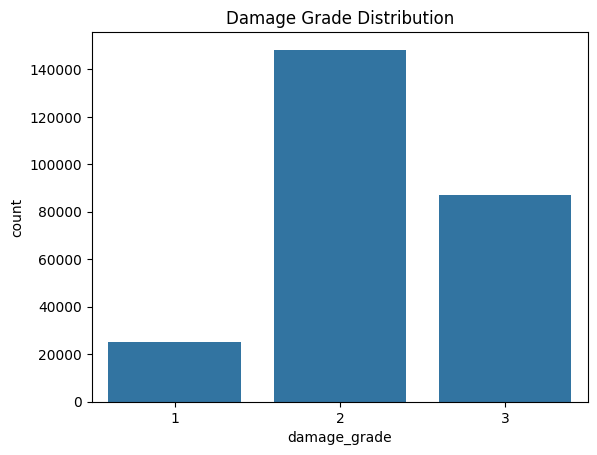

In [ ]:
sns.countplot(x="damage_grade", data=train_labels)
plt.title("Damage Grade Distribution")
plt.show()

Del gráfico anterior, es fácil ver que nuestro conjunto de datos está desbalanceado. La razón por la cual este conjunto de datos está desequilibrado podría deberse al hecho de que los datos se recopilaron después del terremoto de Nepal en 2015, y es muy probable que el grado de daño de los edificios esté altamente correlacionado con la intensidad del terremoto. Es importante mencionar que los árboles de decisión y los bosques aleatorios son extremadamente sensibles a los datos desequilibrados.

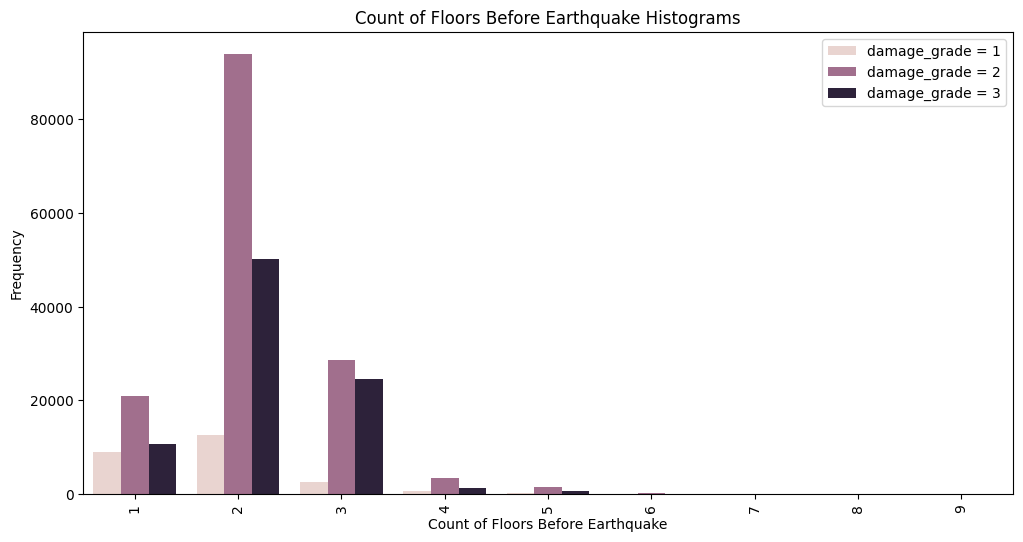

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_values["count_floors_pre_eq"], hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Count of Floors Before Earthquake")
plt.xticks(rotation=90)
plt.title("Count of Floors Before Earthquake Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

Hay edificios en el dataset con 9 plantas, pero la mayorías de las edificaciones afectadas tenían solo dos plantas 2.

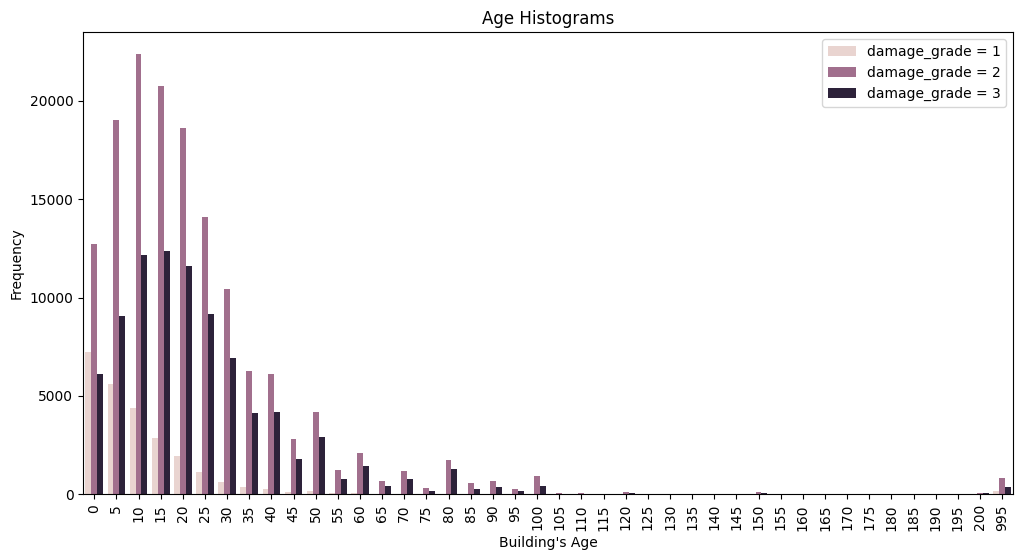

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_values["age"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Building's Age")
plt.xticks(rotation=90)
plt.title("Age Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

Tenemos edificios de aproximadamente 995 años de antigüedad, lo cual a primera vista parece ser un error en la recopilación de datos. Tras una rápida búsqueda en Google, pude determinar que los edificios en Nepal pueden tener esa antigüedad. Sin embargo, todavía tenemos que lidiar con los valores atípicos.

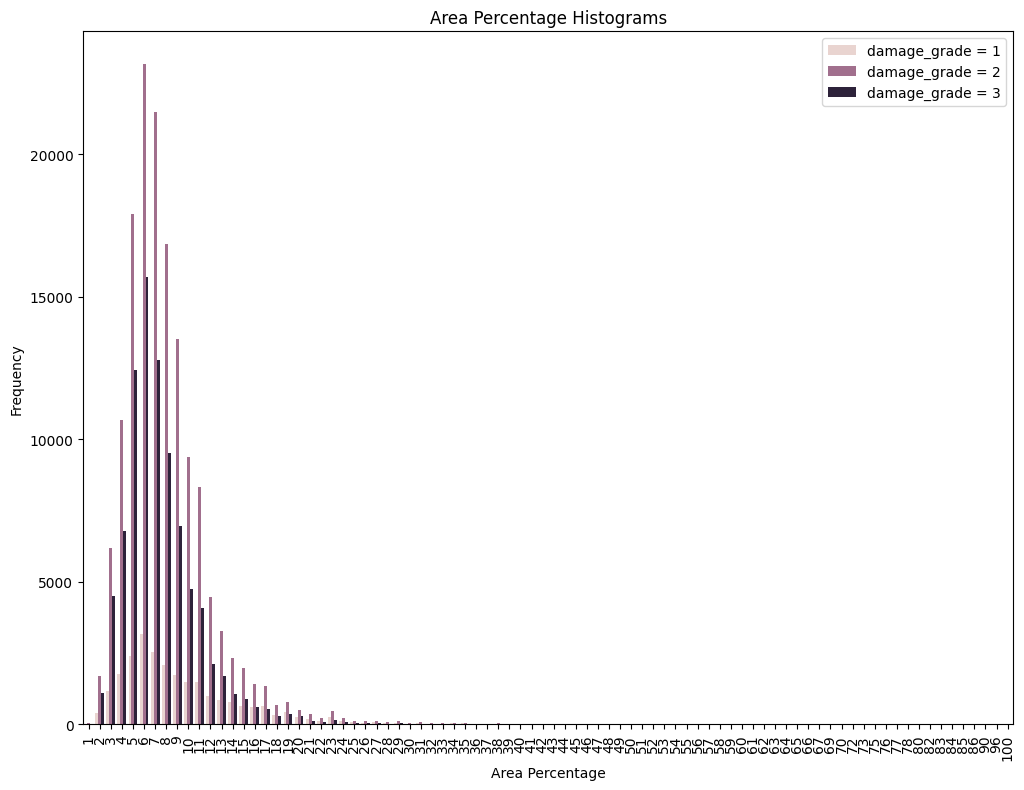

In [ ]:
plt.figure(figsize=(12,9))
sns.countplot(x=train_values["area_percentage"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Area Percentage")
plt.xticks(rotation=90)
plt.title("Area Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

El área normalizada de la huella del edificio es menor al 20% para la mayoría de los edificios. Es importante mencionar que algunos valores llegan hasta el 100%, por lo que es importante que nos ocupemos de los valores atípicos de esta característica.

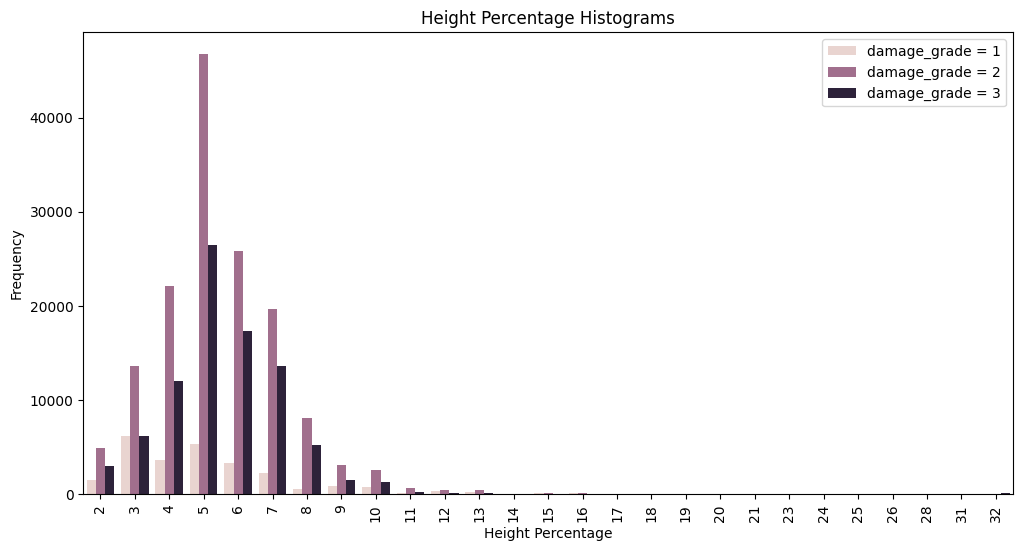

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_values["height_percentage"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Height Percentage")
plt.xticks(rotation=90)
plt.title("Height Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

Una vez más, tenemos otra variable de la que necesitamos eliminar sus valores atípicos. La mayoría de los datos para esta característica son menos del 10%, pero tenemos algunos edificios con valores de hasta el 32%

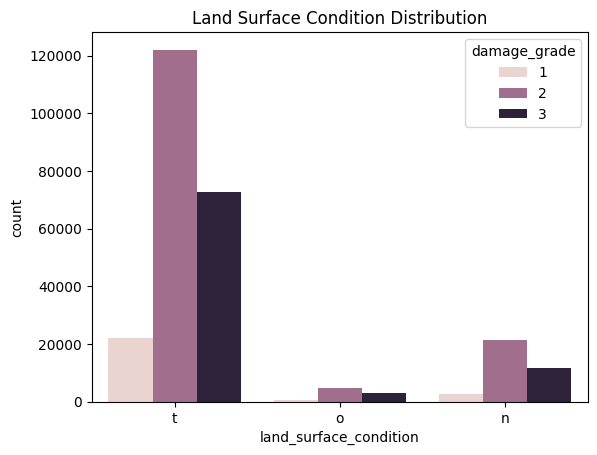

In [ ]:
sns.countplot(x = train_values["land_surface_condition"], hue = train_labels["damage_grade"])
plt.title("Land Surface Condition Distribution")
plt.show()

Esta es una variable categórica que indica la condición de la superficie de la tierra donde el edificio se construyó. Valores posibles: n, o, t.

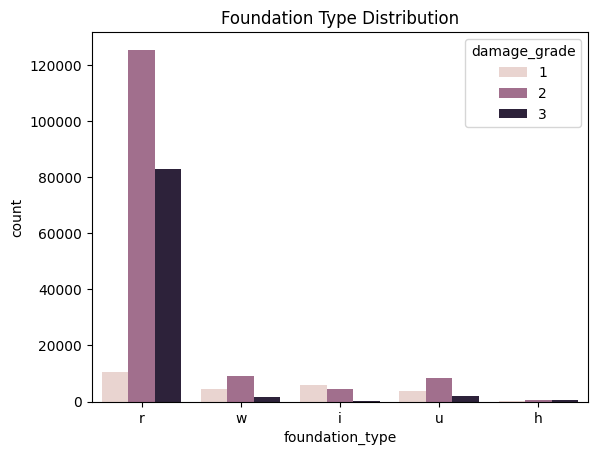

In [ ]:
sns.countplot(x = train_values["foundation_type"], hue = train_labels["damage_grade"])
plt.title("Foundation Type Distribution")
plt.show()

Esta es una variable categórica que indica el tipo de cimentación utilizada durante la construcción. Valores posibles: h, i, r, u, w.

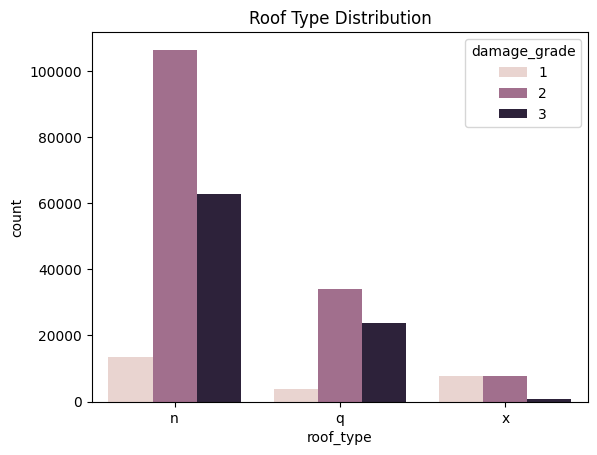

In [ ]:
sns.countplot(x = train_values["roof_type"], hue = train_labels["damage_grade"])
plt.title("Roof Type Distribution")
plt.show()

Esta es una variable categórica que indica el tipo de techo utilizado durante la construcción. Valores posibles: n, q, x.

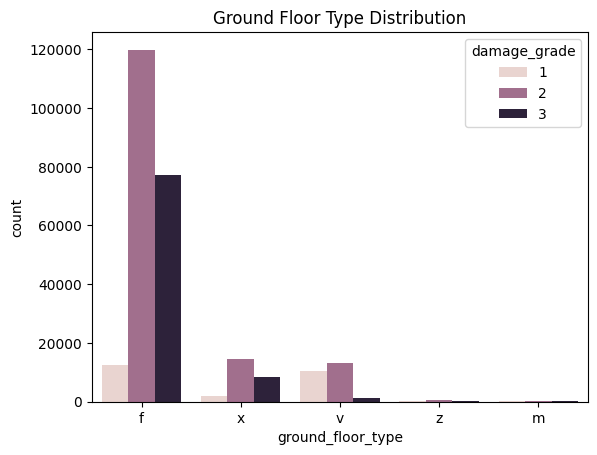

In [ ]:
sns.countplot(x = train_values["ground_floor_type"], hue = train_labels["damage_grade"])
plt.title("Ground Floor Type Distribution")
plt.show()

Esta es una variable categórica que indica el tipo de piso de planta baja. Valores posibles: f, m, v, x, z.

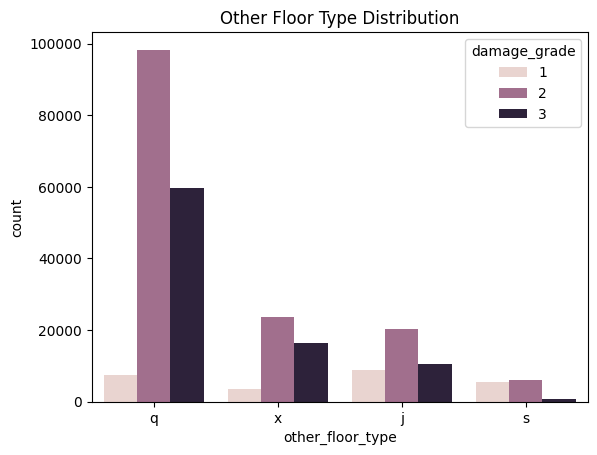

In [ ]:
sns.countplot(x = train_values["other_floor_type"], hue = train_labels["damage_grade"])
plt.title("Other Floor Type Distribution")
plt.show()

Esta es una variable categórica que indica el tipo de construcciones utilizadas en los pisos superiores al suelo (excepto el techo). Valores posibles: j, q, s, x.

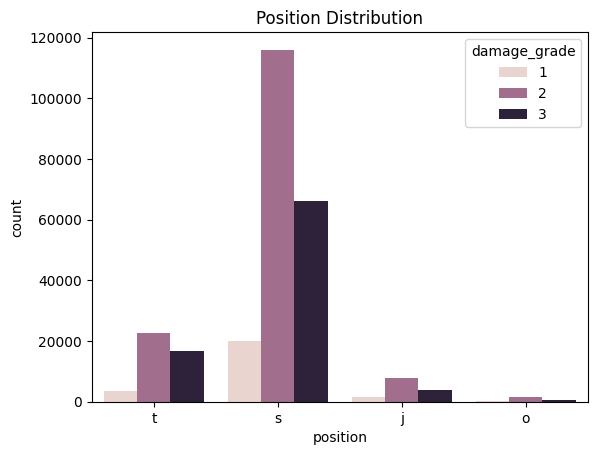

In [ ]:
sns.countplot(x = train_values["position"], hue = train_labels["damage_grade"])
plt.title("Position Distribution")
plt.show()


Esta es una variable categórica que indica la posición del edificio. Valores posibles: j, o, s, t.

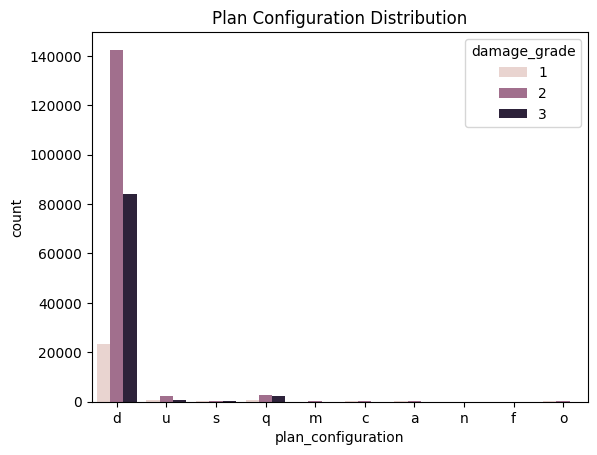

In [ ]:
sns.countplot(x = train_values["plan_configuration"], hue = train_labels["damage_grade"])
plt.title("Plan Configuration Distribution")
plt.show()


Esta es una variable categórica que indica la configuración del plano del edificio. Valores posibles: a, c, d, f, m, n, o, q, s, u.

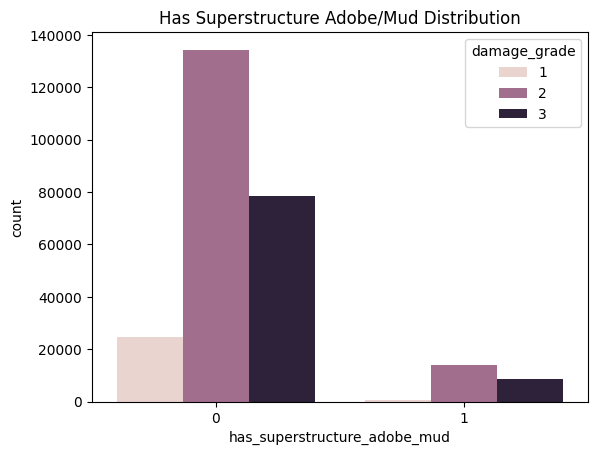

In [ ]:
sns.countplot(x = train_values["has_superstructure_adobe_mud"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Adobe/Mud Distribution")
plt.show()


Esta es una variable de tipo indicador que señala si la superestructura fue hecha de adobe/barro.

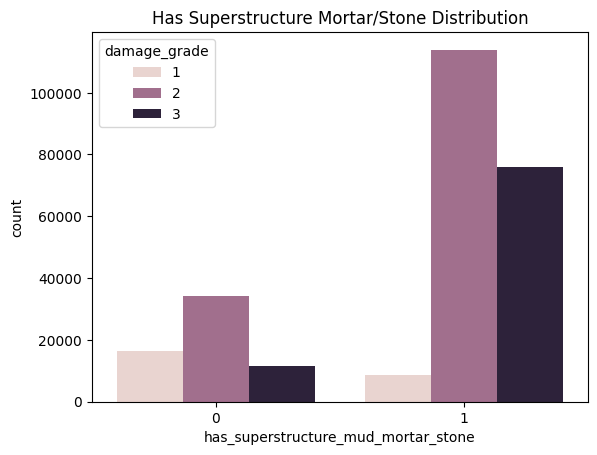

In [ ]:
sns.countplot(x = train_values["has_superstructure_mud_mortar_stone"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Mortar/Stone Distribution")
plt.show()

Esta es una variable de tipo indicador que señala si la superestructura fue hecha de mortero de barro - piedra.

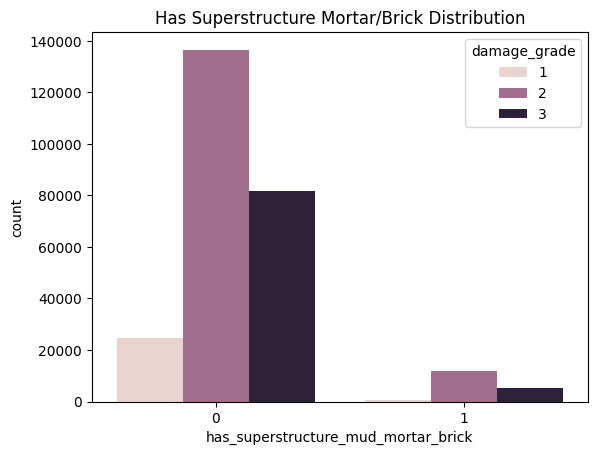

In [ ]:
sns.countplot(x = train_values["has_superstructure_mud_mortar_brick"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Mortar/Brick Distribution")
plt.show()

Esta es una variable de tipo indicador que señala si la superestructura fue hecha de mortero de barro - ladrillo.

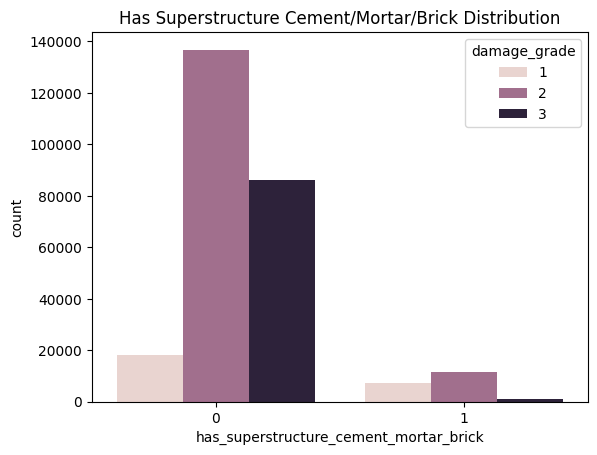

In [ ]:
sns.countplot(x = train_values["has_superstructure_cement_mortar_brick"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Cement/Mortar/Brick Distribution")
plt.show()

Esta es una variable de tipo indicador que señala si la superestructura fue hecha de mortero de cemento - ladrillo.

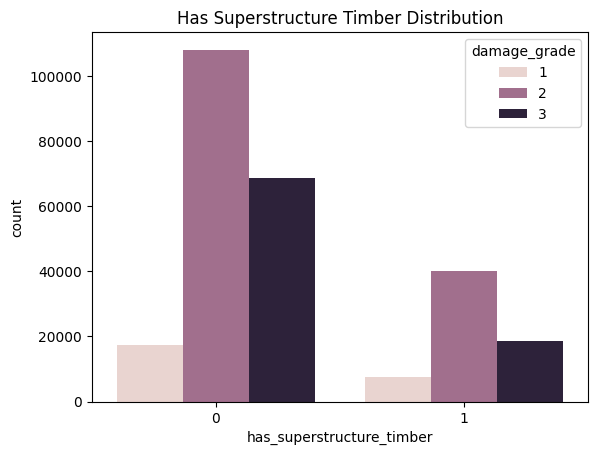

In [ ]:
sns.countplot(x = train_values["has_superstructure_timber"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Timber Distribution")
plt.show()

Esta es una variable de tipo indicador que señala si la superestructura fue hecha de madera.

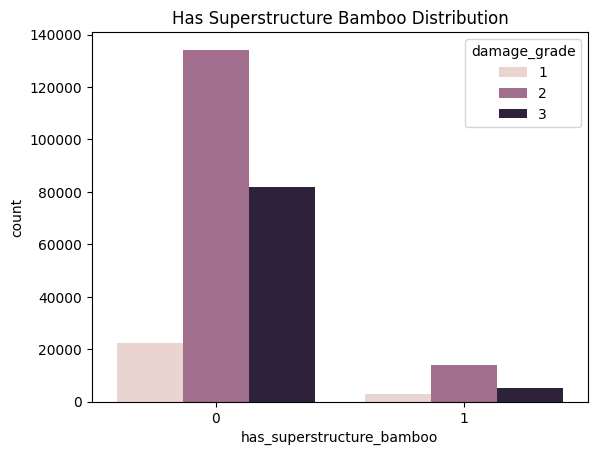

In [ ]:
sns.countplot(x = train_values["has_superstructure_bamboo"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Bamboo Distribution")
plt.show()

Esta es una variable que indica si las superestructura se hizo de Bamboo.

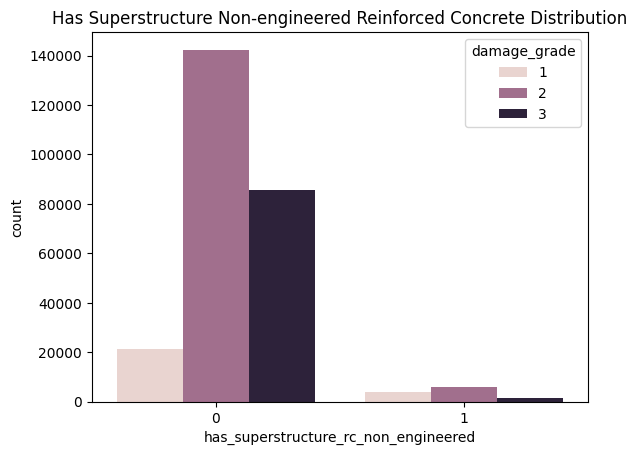

In [ ]:
sns.countplot(x = train_values["has_superstructure_rc_non_engineered"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Non-engineered Reinforced Concrete Distribution")
plt.show()

Esta variable indica si la superestructura fue hecha de cemento no reforzado.

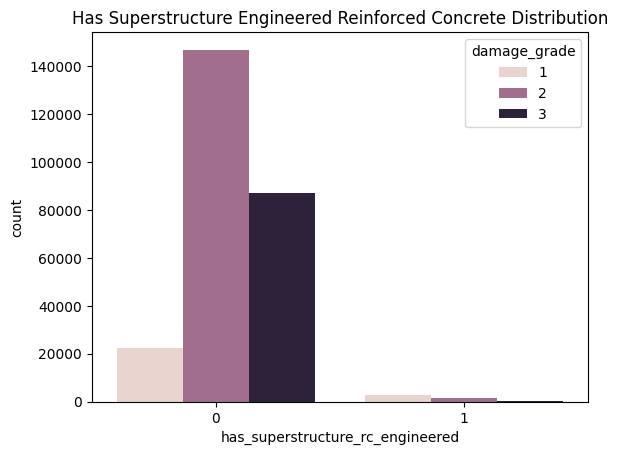

In [ ]:
sns.countplot(x = train_values["has_superstructure_rc_engineered"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Engineered Reinforced Concrete Distribution")
plt.show()

Esta es una variable que indica si la superestructura fue hecha de cemento reforzado.

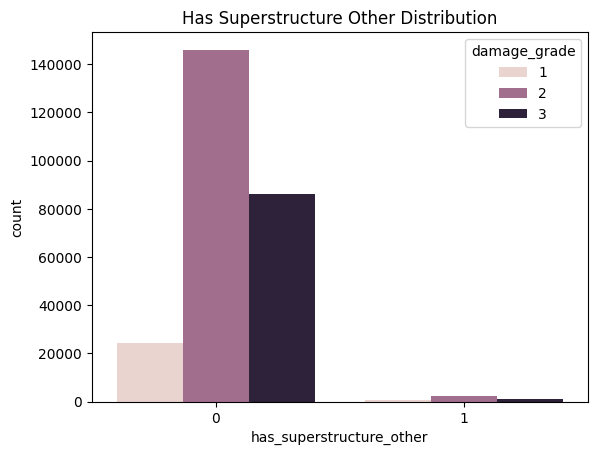

In [ ]:
sns.countplot(x = train_values["has_superstructure_other"], hue = train_labels["damage_grade"])
plt.title("Has Superstructure Other Distribution")
plt.show()

Esta variable indica si la superestructura está hecha de cualquier otro material.

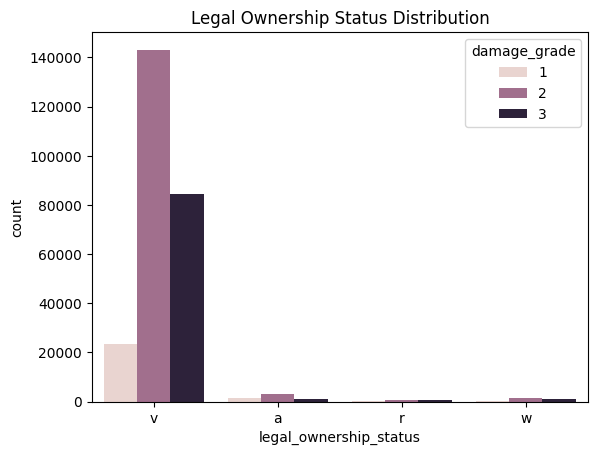

In [ ]:
sns.countplot(x = train_values["legal_ownership_status"], hue = train_labels["damage_grade"])
plt.title("Legal Ownership Status Distribution")
plt.show()

Esta es una variable categórica que indica el estado legal de propiedad del terreno donde se construyó el edificio. Valores posibles: a, r, v, w.

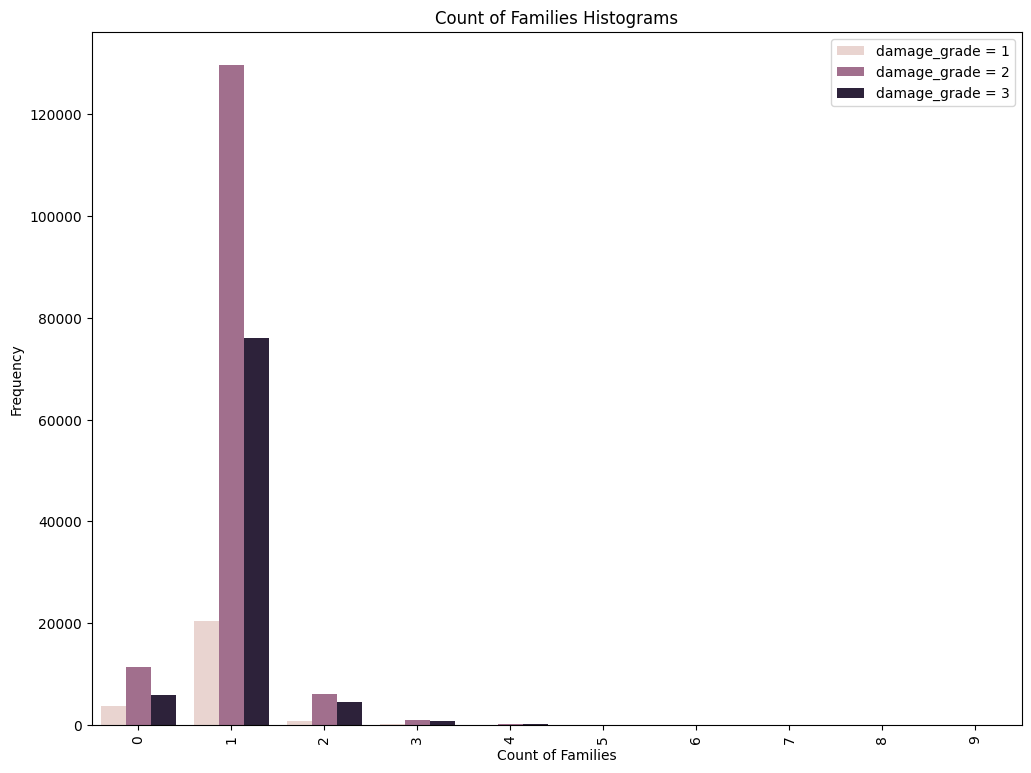

In [ ]:
plt.figure(figsize=(12,9))
sns.countplot(x=train_values["count_families"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Count of Families")
plt.xticks(rotation=90)
plt.title("Count of Families Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

La mayoría de los edificios tenían una familia viviendo en ellos. También hay edificios dode había 9 familias viviendo en ellos, aquellos edificios con 9 plantas.

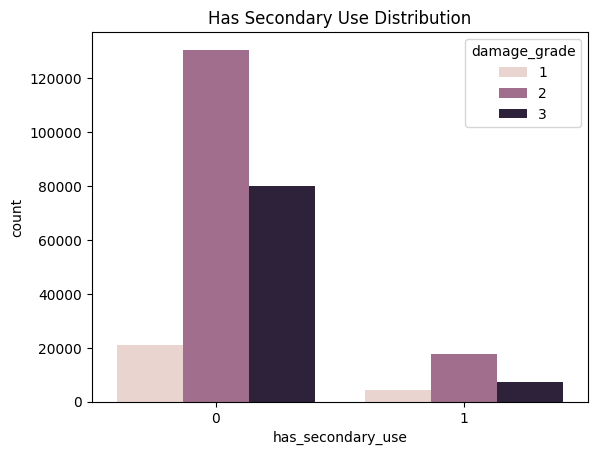

In [ ]:
sns.countplot(x = train_values["has_secondary_use"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Distribution")
plt.show()

Esta es una variable que indica si el edificio se utilizó para otros propósitos.

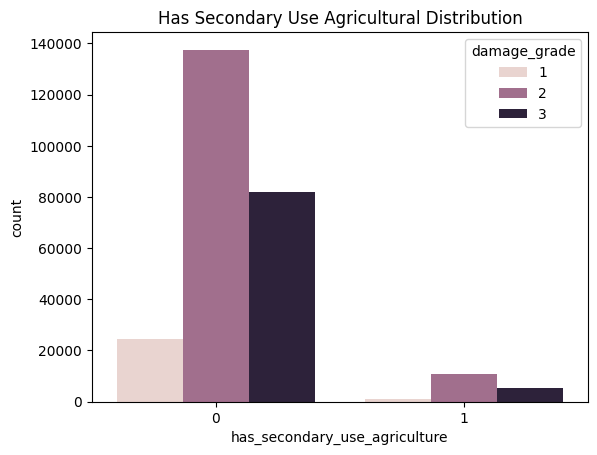

In [ ]:
sns.countplot(x = train_values["has_secondary_use_agriculture"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Agricultural Distribution")
plt.show()

Esta es una variable que indica si el edificio se usó para fines de agricultura.

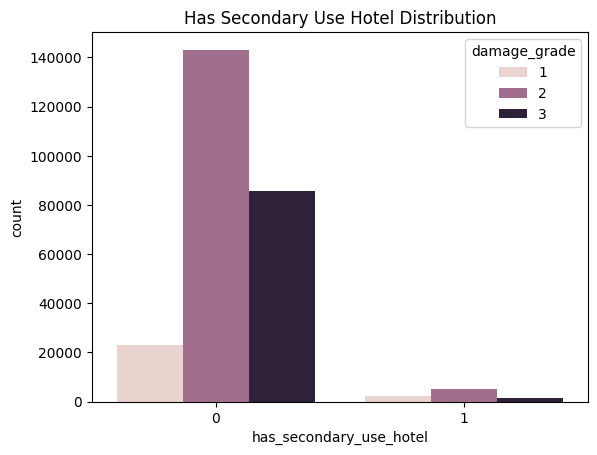

In [ ]:
sns.countplot(x = train_values["has_secondary_use_hotel"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Hotel Distribution")
plt.show()

Esta es un variable que indica si el edificio era un hotel.

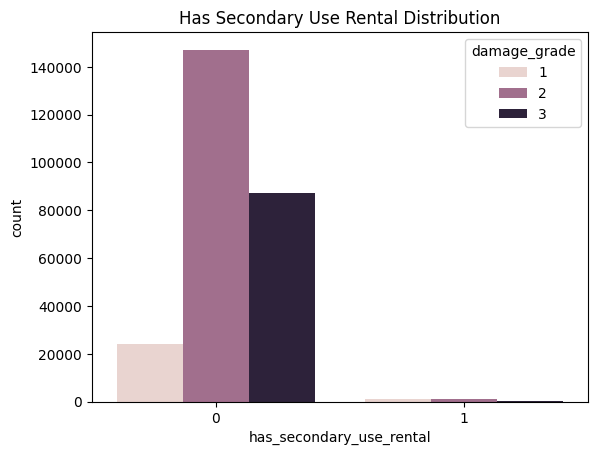

In [ ]:
sns.countplot(x = train_values["has_secondary_use_rental"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Rental Distribution")
plt.show()

Esta es una variable que indica si el edificio se usó para alquilar.

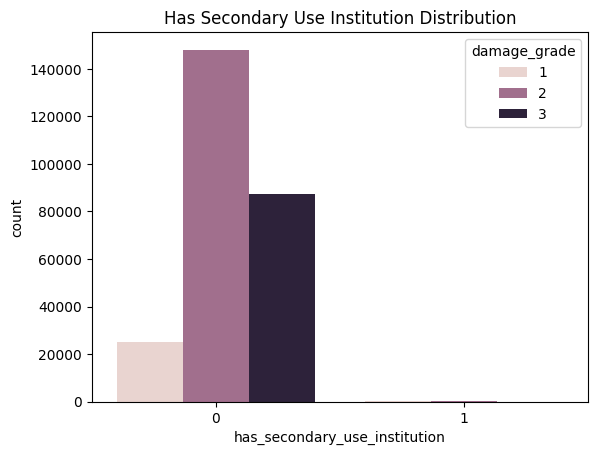

In [ ]:
sns.countplot(x = train_values["has_secondary_use_institution"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Institution Distribution")
plt.show()

Esta es una variable que indica si el edificio se utilizó para alguna institución.

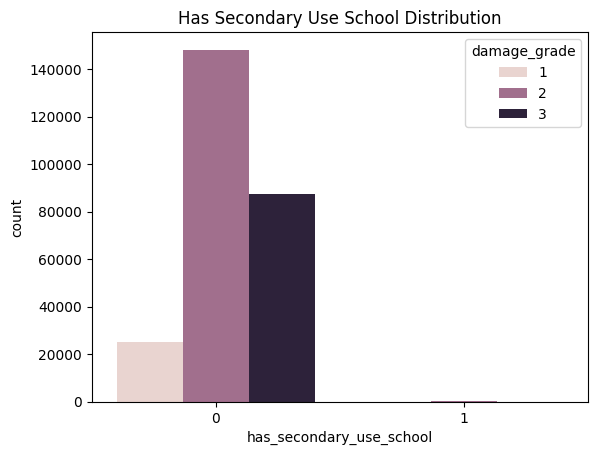

In [ ]:
sns.countplot(x = train_values["has_secondary_use_school"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use School Distribution")
plt.show()

Esta es una variable que indica si el edificio se utilizó como una escuela.

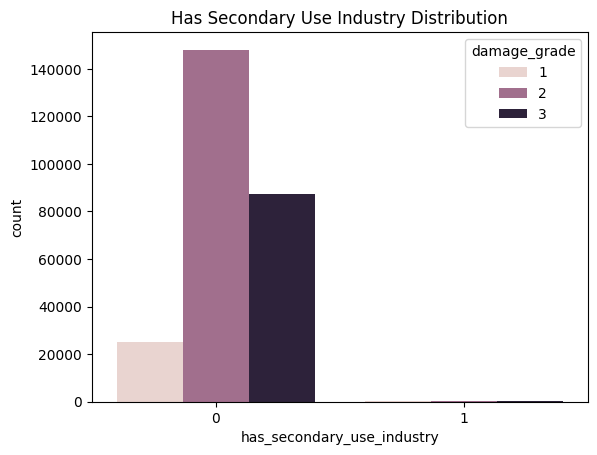

In [ ]:
sns.countplot(x = train_values["has_secondary_use_industry"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Industry Distribution")
plt.show()

Esta es una variable de tipo indicador que señala si el edificio se utilizó para propósitos industriales.

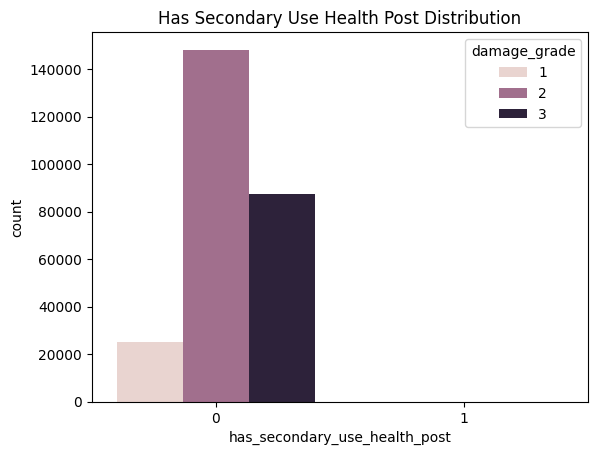

In [ ]:
sns.countplot(x = train_values["has_secondary_use_health_post"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Health Post Distribution")
plt.show()

Esta es una variable de tipo indicador que señala si el edificio se utilizó como puesto de salud.

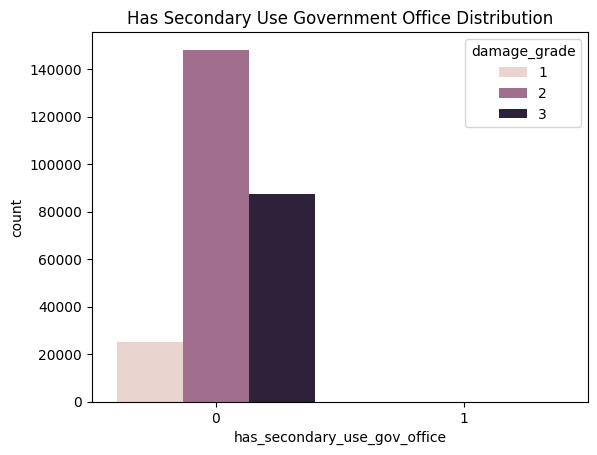

In [ ]:
sns.countplot(x = train_values["has_secondary_use_gov_office"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Government Office Distribution")
plt.show()

Esta es una variable que indica si el edificio se usó como oficina gubernamental.

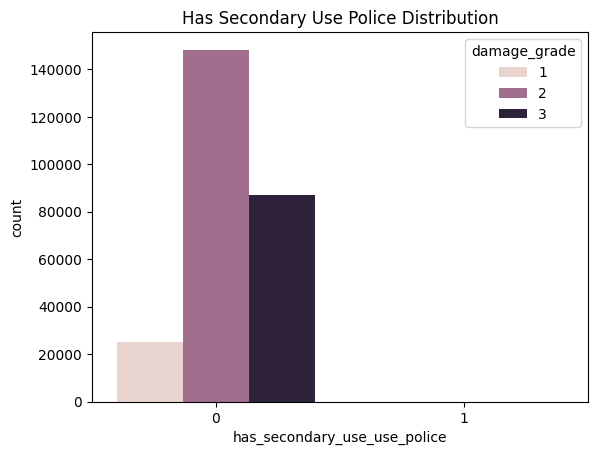

In [ ]:
sns.countplot(x = train_values["has_secondary_use_use_police"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Police Distribution")
plt.show()

Esta es una variable que indica si el edificio se usó como una dependencia policial.

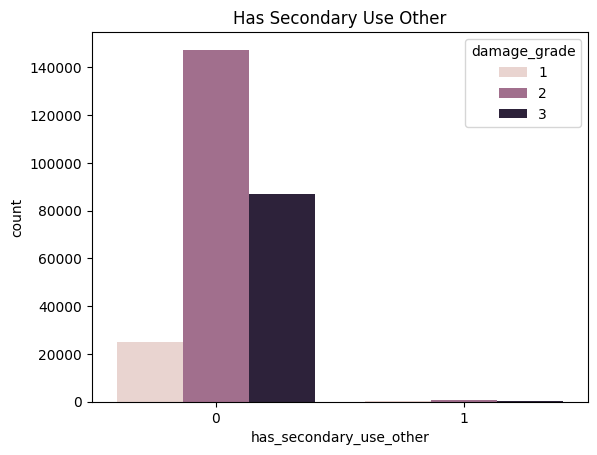

In [ ]:
sns.countplot(x = train_values["has_secondary_use_other"], hue = train_labels["damage_grade"])
plt.title("Has Secondary Use Other")
plt.show()

Esta es una variable que indica si el edificio se utilizaba de forma secundaria para otros propósitos.

## **Outliers**

Aplicamos **Winsorization** al dataset usando la **función winsorize** del módulo scipy.stats.mstats. La Winsorización es un método estadístico que se aplica a un conjunto de datos para limitar valores extremos y reducir el efecto de los valores atípicos.

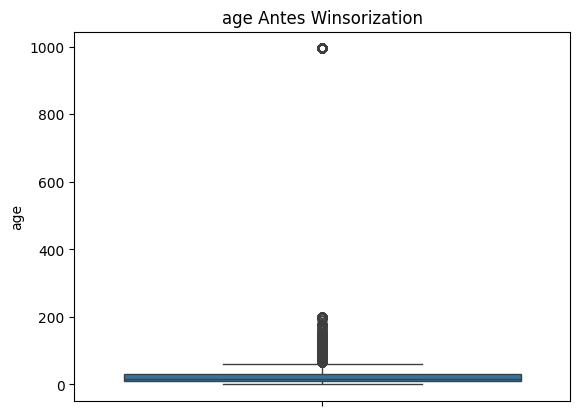

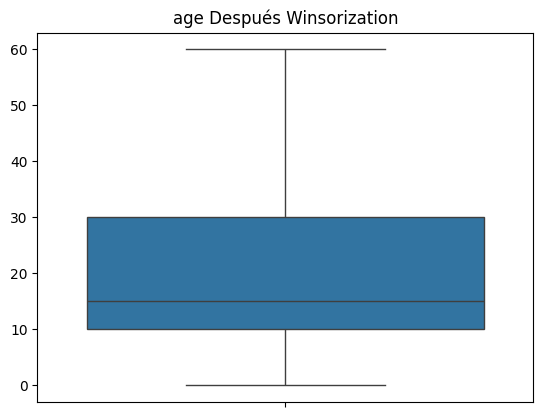

In [ ]:
# Inicialización de la Fuente de Datos
name = "age"
data = train_values[name]

# Visualización de Datos Antes de la Winsorización:
sns.boxplot(data)  # Un diagrama de caja muestra visualmente la distribución de los datos, incluyendo la mediana, cuartiles y posibles valores atípicos.
plt.title("{} Antes Winsorization".format(name))
plt.show()

# Aplicamos Winsorización
winsorized_data = winsorize(data,(0, 0.05))
# La función winsorize se utiliza para aplicar la Winsorización a los datos. La tupla (0, 0.05) como segundo argumento indica que la función debe limitar el 5% superior de los datos.
# El valor 0 significa que no hay limitación en el extremo inferior (no se ajustan los valores más pequeños).
# Esta función reemplaza todos los puntos de datos por encima del percentil 95 con el valor en el percentil 95.

# Después winsorización
sns.boxplot(winsorized_data)
plt.title("{} Después Winsorization".format(name))
plt.show()

# Reemplazo de Datos en el Conjunto de Datos
train_values[name] = winsorized_data

Finalmente, los datos de edad originales en el DataFrame train_values se reemplazan con los datos winsorizados. Este paso modifica el conjunto de datos original con los datos ajustados, que ahora son menos susceptibles a la influencia de valores atípicos en el extremo superior.

Este procedimiento demuestra efectivamente cómo preprocesar datos limitando valores extremos para hacer el análisis estadístico subsiguiente más robusto y confiable. La Winsorización es especialmente útil en conjuntos de datos donde los valores extremos pueden sesgar los resultados.

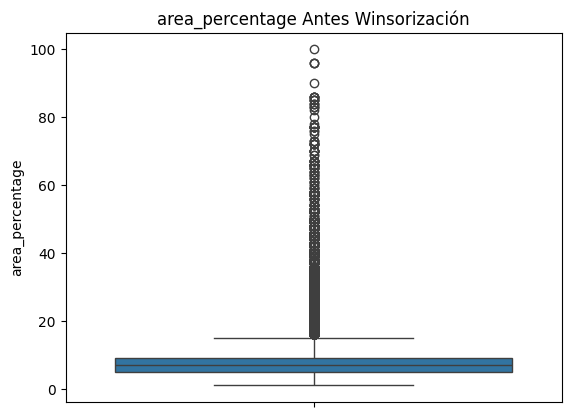

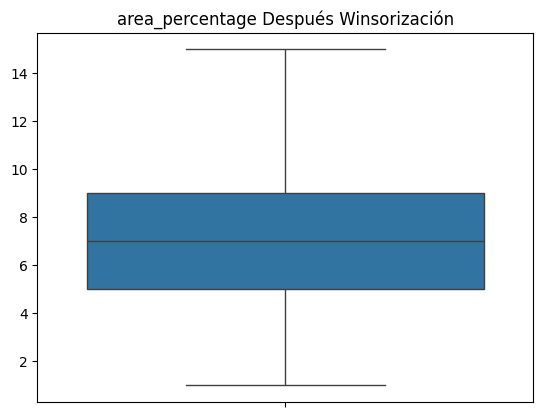

In [ ]:
# Fuente de datos
name = "area_percentage"
data = train_values[name]

# Antes winsorización
sns.boxplot(data)
plt.title("{} Antes Winsorización".format(name))
plt.show()

# Winsorización
winsorized_data = winsorize(data,(0, 0.055))

# Después de la winsorización
sns.boxplot(winsorized_data)
plt.title("{} Después Winsorización".format(name))
plt.show()

# Reemplazo de datos en el dataset
train_values[name] = winsorized_data

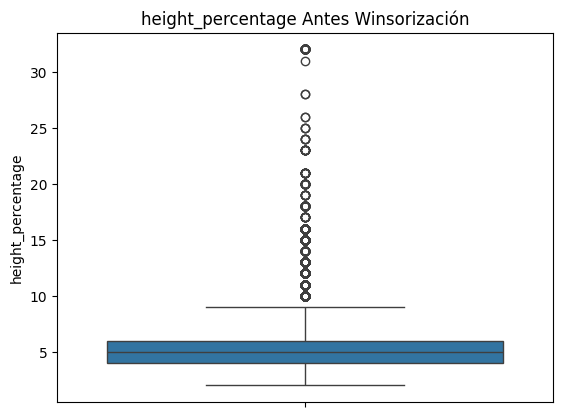

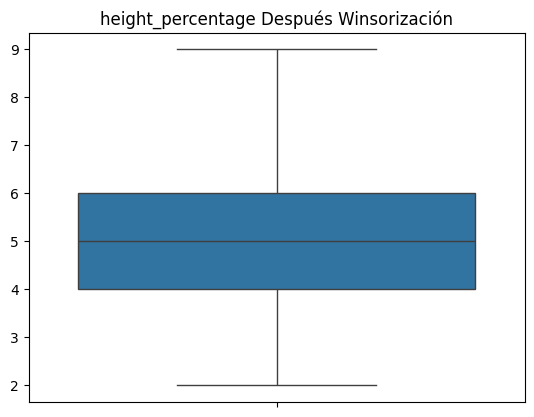

In [ ]:
# Fuente de datos
name = "height_percentage"
data = train_values[name]

# Antes winsorización
sns.boxplot(data)
plt.title("{} Antes Winsorización".format(name))
plt.show()

# Winsorización
winsorized_data = winsorize(data,(0, 0.04))

# Después de la winsorización
sns.boxplot(winsorized_data)
plt.title("{} Después Winsorización".format(name))
plt.show()

# Reemplazo de datos en el dataset
train_values[name] = winsorized_data

Elegimos las columnas comunes de los dataset de dataset_train_values y dataset_train_labels y fusionamos ambas para tener un dataset único para entrenar.

In [ ]:
common_columns = ['building_id']
df = pd.merge(train_values, train_labels, on=common_columns)
df.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6             487           12198   
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type  ... has_secondary_use_hotel  \
0                      t               r  ...                       0   
1                      o               r  ...                       0   
2                      t               r  ...                       0   
3                      t               r  ...                       0   
4                      t               r  ...                       0   

  has_secondary_use_rental has_secondary_use_institution  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   

  has_secondary_use_school has_secondary_use_industry  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                          0   
4                        0                          0   

   has_secondary_use_health_post  has_secondary_use_gov_office  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   has_secondary_use_use_police  has_secondary_use_other  damage_grade  
0                             0                        0             3  
1                             0                        0             2  
2                             0                        0             3  
3                             0                        0             2  
4                             0                        0             3  

[5 rows x 40 columns]

Comprobamos que el id del edificio por el que hemos unido las tablas no guarda ninguna relación con el riesgo de derrumbamiento. Con ello podemos observar que la enumeración de los edificios no guarda relación con el grado de daño de los mismos y es irrelevante para la predicción.

In [ ]:
print(df.shape)

(260601, 40)


Comprobamos si hay valores duplicados en el dataset

In [ ]:
# Comprobamos los duplicados
print('Antes de borrar duplicados', df.shape)
df.drop_duplicates(subset='building_id', keep='last')
print('Después de borrar duplicados', df.shape)

Antes de borrar duplicados (260601, 40)
Después de borrar duplicados (260601, 40)


In [ ]:
df.head(5)

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6             487           12198   
1        28830               8             900            2812   
2        94947              21             363            8973   
3       590882              22             418           10694   
4       201944              11             131            1488   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   

  land_surface_condition foundation_type  ... has_secondary_use_hotel  \
0                      t               r  ...                       0   
1                      o               r  ...                       0   
2                      t               r  ...                       0   
3                      t               r  ...                       0   
4                      t               r  ...                       0   

  has_secondary_use_rental has_secondary_use_institution  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   

  has_secondary_use_school has_secondary_use_industry  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                          0   
4                        0                          0   

   has_secondary_use_health_post  has_secondary_use_gov_office  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   has_secondary_use_use_police  has_secondary_use_other  damage_grade  
0                             0                        0             3  
1                             0                        0             2  
2                             0                        0             3  
3                             0                        0             2  
4                             0                        0             3  

[5 rows x 40 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

## **Selección de filas**
Debido al elevado tamaño del dataset voy a filtrar la zona 6 porque tiene un número suficiente de registros para el estudio y hay datos en las tres clases de 'damage_grade' 1: bajo, 2: medio, 3: alto

In [ ]:
df_filt=df[df['geo_level_1_id'] == 6]

In [ ]:
df_filt.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0        802906               6             487           12198   
16       633759               6             706           12267   
32       157370               6             706           11722   
38        33651               6            1210            9423   
44      1005736               6             724            7981   

    count_floors_pre_eq  age  area_percentage  height_percentage  \
0                     2   30                6                  5   
16                    2    5                7                  5   
32                    2   20                4                  4   
38                    3   40                5                  7   
44                    2   10                5                  5   

   land_surface_condition foundation_type  ... has_secondary_use_hotel  \
0                       t               r  ...                       0   
16                      t               r  ...                       0   
32                      t               r  ...                       0   
38                      t               r  ...                       0   
44                      t               r  ...                       0   

   has_secondary_use_rental has_secondary_use_institution  \
0                         0                             0   
16                        0                             0   
32                        0                             0   
38                        0                             0   
44                        0                             0   

   has_secondary_use_school has_secondary_use_industry  \
0                         0                          0   
16                        0                          0   
32                        0                          0   
38                        0                          0   
44                        0                          0   

    has_secondary_use_health_post  has_secondary_use_gov_office  \
0                               0                             0   
16                              0                             0   
32                              0                             0   
38                              0                             0   
44                              0                             0   

    has_secondary_use_use_police  has_secondary_use_other  damage_grade  
0                              0                        0             3  
16                             0                        0             2  
32                             0                        0             2  
38                             0                        0             3  
44                             0                        0             2  

[5 rows x 40 columns]

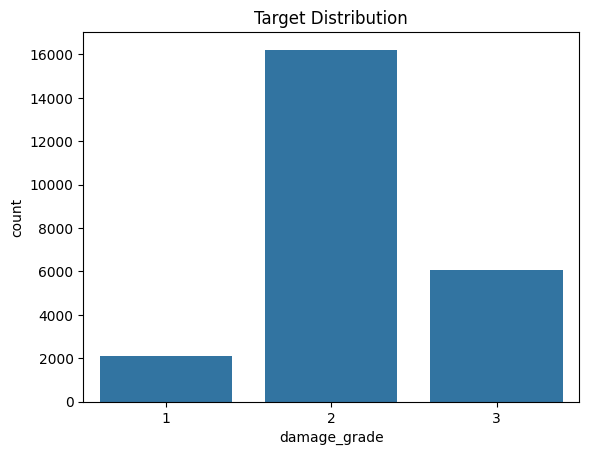

In [ ]:
# Comprobamos la distribución de la variable objetivo
sns.countplot(x='damage_grade', data=df_filt,)
plt.title('Target Distribution');

###La distribución de la variable objetivo está desbalanceada

In [ ]:
df_filt['damage_grade'].value_counts()

damage_grade
2    16222
3     6051
1     2108
Name: count, dtype: int64

### Tenemos que balancear los datos antes de aplicar los algoritmos###

Después de numerosas pruebas, volvemos a truncar los datos, para balancearlos totalmente, eligiendo 2108 para cada valor de la etiqueta (1,2,ó 3)


In [ ]:
# Filtrar 2108 filas para cada valor de etiqueta
df_filt1 = df_filt[df_filt['damage_grade'] == 1].head(2108)
df_filt2 = df_filt[df_filt['damage_grade'] == 2].head(2108)
df_filt3 = df_filt[df_filt['damage_grade'] == 3].head(2108)

# Concatenar los resultados en un nuevo dataframe
df_filt_reducido = pd.concat([df_filt1, df_filt2, df_filt3])

## **Transformación de datos**
Vamos a transformar los tipos de datos de las columnas categóricas a datos numéricos

In [ ]:
# Copiamos los datasets sin transformar
df_transf= df_filt_reducido.copy()

df_test_transf = test_values.copy()

# Valores categóricos de cada columna
print('land_surface_condition - Valores:', df_transf['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_transf['foundation_type'].unique())
print('roof_type              - Valores:', df_transf['roof_type'].unique())
print('ground_floor_type      - Valores:', df_transf['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_transf['other_floor_type'].unique())
print('position               - Valores:', df_transf['position'].unique())
print('plan_configuration     - Valores:', df_transf['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_transf['legal_ownership_status'].unique())

land_surface_condition - Valores: ['t' 'n' 'o']
foundation_type        - Valores: ['i' 'r' 'u' 'h' 'w']
roof_type              - Valores: ['x' 'n' 'q']
ground_floor_type      - Valores: ['x' 'v' 'f' 'm' 'z']
other_floor_type       - Valores: ['s' 'j' 'q' 'x']
position               - Valores: ['s' 'j' 't' 'o']
plan_configuration     - Valores: ['d' 'u' 'q' 'c' 'a' 's' 'o' 'f']
legal_ownership_status - Valores: ['v' 'a' 'w' 'r']


Asignamos valores numéricos a cada uno de los valores categóricos de cada columna

In [ ]:
df_transf["land_surface_condition"].replace(['t', 'o', 'n'],[0, 1, 2], inplace=True)
df_transf["foundation_type"].replace(['r', 'w', 'i', 'u', 'h'],[0, 1, 2, 3, 4], inplace=True)
df_transf["roof_type"].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
df_transf["ground_floor_type"].replace(['f', 'x', 'v', 'z', 'm',],[0, 1, 2, 3, 4], inplace=True)
df_transf["other_floor_type"].replace(['q', 'x', 'j', 's'],[0, 1, 2, 3], inplace=True)
df_transf["position"].replace(['t', 's', 'j', 'o'],[0, 1, 2, 3], inplace=True)
df_transf["plan_configuration"].replace(['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
df_transf["legal_ownership_status"].replace(['v', 'a', 'r', 'w'],[0, 1, 2, 3], inplace=True)

In [ ]:
df_transf.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
248       920565               6            1350            5830   
262       747500               6            1253            3073   
314        15665               6             845            9204   
362       363074               6             898            5641   
466       758110               6            1181            7711   

     count_floors_pre_eq  age  area_percentage  height_percentage  \
248                    2    0               15                  7   
262                    3    5               15                  9   
314                    4    5               15                  9   
362                    1    0               12                  3   
466                    2    5                8                  5   

     land_surface_condition  foundation_type  ...  has_secondary_use_hotel  \
248                       0                2  ...                        0   
262                       0                2  ...                        0   
314                       0                2  ...                        1   
362                       0                0  ...                        0   
466                       0                0  ...                        0   

     has_secondary_use_rental  has_secondary_use_institution  \
248                         0                              0   
262                         0                              0   
314                         0                              0   
362                         0                              0   
466                         0                              0   

     has_secondary_use_school  has_secondary_use_industry  \
248                         0                           0   
262                         0                           0   
314                         0                           0   
362                         0                           0   
466                         0                           0   

     has_secondary_use_health_post  has_secondary_use_gov_office  \
248                              0                             0   
262                              0                             0   
314                              0                             0   
362                              0                             0   
466                              0                             0   

     has_secondary_use_use_police  has_secondary_use_other  damage_grade  
248                             0                        0             1  
262                             0                        0             1  
314                             0                        0             1  
362                             0                        0             1  
466                             0                        0             1  

[5 rows x 40 columns]

Ahora para el dataframe de test

In [ ]:
df_test_transf["land_surface_condition"].replace(['t', 'o', 'n'],[0, 1, 2], inplace=True)
df_test_transf["foundation_type"].replace(['r', 'w', 'i', 'u', 'h'],[0, 1, 2, 3, 4], inplace=True)
df_test_transf["roof_type"].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
df_test_transf["ground_floor_type"].replace(['f', 'x', 'v', 'z', 'm',],[0, 1, 2, 3, 4], inplace=True)
df_test_transf["other_floor_type"].replace(['q', 'x', 'j', 's'],[0, 1, 2, 3], inplace=True)
df_test_transf["position"].replace(['t', 's', 'j', 'o'],[0, 1, 2, 3], inplace=True)
df_test_transf["plan_configuration"].replace(['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
df_test_transf["legal_ownership_status"].replace(['v', 'a', 'r', 'w'],[0, 1, 2, 3], inplace=True)

In [ ]:
# Comprobamos los valores de las columnas
print('land_surface_condition - Valores:', df_transf['land_surface_condition'].unique())
print('foundation_type        - Valores:', df_transf['foundation_type'].unique())
print('roof_type              - Valores:', df_transf['roof_type'].unique())
print('ground_floor_type      - Valores:', df_transf['ground_floor_type'].unique())
print('other_floor_type       - Valores:', df_transf['other_floor_type'].unique())
print('position               - Valores:', df_transf['position'].unique())
print('plan_configuration     - Valores:', df_transf['plan_configuration'].unique())
print('legal_ownership_status - Valores:', df_transf['legal_ownership_status'].unique())

land_surface_condition - Valores: [0 2 1]
foundation_type        - Valores: [2 0 3 4 1]
roof_type              - Valores: [2 0 1]
ground_floor_type      - Valores: [1 2 0 4 3]
other_floor_type       - Valores: [3 2 0 1]
position               - Valores: [1 2 0 3]
plan_configuration     - Valores: [0 1 3 5 6 2 9 8]
legal_ownership_status - Valores: [0 1 3 2]


In [ ]:
# Comprobamos los tipos de datos tras las transformaciones
df_transf.dtypes

building_id                               int64
geo_level_1_id                            int64
geo_level_2_id                            int64
geo_level_3_id                            int64
count_floors_pre_eq                       int64
age                                       int64
area_percentage                           int64
height_percentage                         int64
land_surface_condition                    int64
foundation_type                           int64
roof_type                                 int64
ground_floor_type                         int64
other_floor_type                          int64
position                                  int64
plan_configuration                        int64
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick  

## **Escalamiento**

Escalamos todas las columnas numéricas

In [ ]:
Scaler=MinMaxScaler()

scaled_data = Scaler.fit_transform(df_transf)
df_train_scaled = pd.DataFrame(scaled_data, columns=df_transf.columns)

scaled_data = Scaler.fit_transform(df_test_transf)
df_test_scaled = pd.DataFrame(scaled_data, columns=df_test_transf.columns)

In [ ]:
df_train_scaled.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0         0.87            0.00            0.97            0.46   
1         0.71            0.00            0.90            0.24   
2         0.01            0.00            0.61            0.73   
3         0.34            0.00            0.65            0.45   
4         0.72            0.00            0.85            0.61   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                 0.17 0.00             1.00               0.71   
1                 0.33 0.08             1.00               1.00   
2                 0.50 0.08             1.00               1.00   
3                 0.00 0.00             0.79               0.14   
4                 0.17 0.08             0.50               0.43   

   land_surface_condition  foundation_type  ...  has_secondary_use_hotel  \
0                    0.00             0.50  ...                     0.00   
1                    0.00             0.50  ...                     0.00   
2                    0.00             0.50  ...                     1.00   
3                    0.00             0.00  ...                     0.00   
4                    0.00             0.00  ...                     0.00   

   has_secondary_use_rental  has_secondary_use_institution  \
0                      0.00                           0.00   
1                      0.00                           0.00   
2                      0.00                           0.00   
3                      0.00                           0.00   
4                      0.00                           0.00   

   has_secondary_use_school  has_secondary_use_industry  \
0                      0.00                        0.00   
1                      0.00                        0.00   
2                      0.00                        0.00   
3                      0.00                        0.00   
4                      0.00                        0.00   

   has_secondary_use_health_post  has_secondary_use_gov_office  \
0                           0.00                          0.00   
1                           0.00                          0.00   
2                           0.00                          0.00   
3                           0.00                          0.00   
4                           0.00                          0.00   

   has_secondary_use_use_police  has_secondary_use_other  damage_grade  
0                          0.00                     0.00          0.00  
1                          0.00                     0.00          0.00  
2                          0.00                     0.00          0.00  
3                          0.00                     0.00          0.00  
4                          0.00                     0.00          0.00  

[5 rows x 40 columns]

In [ ]:
df_test_scaled.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0         0.28            0.57            0.42            0.90   
1         0.09            0.20            0.10            0.95   
2         0.85            0.73            0.01            0.80   
3         0.71            0.87            0.03            0.05   
4         0.40            0.57            0.20            0.63   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                 0.29 0.02             0.07               0.13   
1                 0.14 0.03             0.13               0.10   
2                 0.14 0.01             0.03               0.10   
3                 0.00 0.00             0.20               0.03   
4                 0.29 0.02             0.08               0.17   

   land_surface_condition  foundation_type  ...  \
0                    0.00             0.00  ...   
1                    0.00             0.00  ...   
2                    0.00             0.00  ...   
3                    0.00             0.00  ...   
4                    0.00             0.00  ...   

   has_secondary_use_agriculture  has_secondary_use_hotel  \
0                           0.00                     0.00   
1                           1.00                     0.00   
2                           0.00                     0.00   
3                           0.00                     0.00   
4                           0.00                     0.00   

   has_secondary_use_rental  has_secondary_use_institution  \
0                      0.00                           0.00   
1                      0.00                           0.00   
2                      0.00                           0.00   
3                      1.00                           0.00   
4                      0.00                           0.00   

   has_secondary_use_school  has_secondary_use_industry  \
0                      0.00                        0.00   
1                      0.00                        0.00   
2                      0.00                        0.00   
3                      0.00                        0.00   
4                      0.00                        0.00   

   has_secondary_use_health_post  has_secondary_use_gov_office  \
0                           0.00                          0.00   
1                           0.00                          0.00   
2                           0.00                          0.00   
3                           0.00                          0.00   
4                           0.00                          0.00   

   has_secondary_use_use_police  has_secondary_use_other  
0                          0.00                     0.00  
1                          0.00                     0.00  
2                          0.00                     0.00  
3                          0.00                     0.00  
4                          0.00                     0.00  

[5 rows x 39 columns]

##**Separamos los datos de train y de validación**

Elegimos un 80% para train y un 20% para validación. Hay que separar los datos de manera estratificada, para que haya datos de todas las etiquetas en los dos conjuntos de datos

In [ ]:
df_train_sp, df_valid_sp = train_test_split(df_train_scaled, test_size=0.1, stratify=df_train_scaled['damage_grade'], random_state=42)

Obtenemos la distribución de datos en cada una de las clases, para los entornos de entrenamiento y validación.

In [ ]:
print('Datos de train')
print('------------------------------------------')
print(df_train_sp['damage_grade'].value_counts())
print('------------------------------------------')
print('Porcentajes')
print('------------------------------------------')
porcentajes=(df_train_sp['damage_grade'].value_counts()/len(df_train_sp))*100
porcentaje_form= porcentajes.apply(lambda x: "{:.2f}%".format(x))
print(porcentaje_form)

Datos de train
------------------------------------------
damage_grade
0.50    1897
1.00    1897
0.00    1897
Name: count, dtype: int64
------------------------------------------
Porcentajes
------------------------------------------
damage_grade
0.50    33.33%
1.00    33.33%
0.00    33.33%
Name: count, dtype: object


In [ ]:
print('Datos de validación')
print('-----------------------------------------------')
print(df_valid_sp['damage_grade'].value_counts())

porcentajes=(df_valid_sp['damage_grade'].value_counts()/len(df_valid_sp))*100
porcentaje_form= porcentajes.apply(lambda x: "{:.2f}%".format(x))
print('------------------------------------------')
print('Porcentajes')
print('------------------------------------------')
print (porcentaje_form)

Datos de validación
-----------------------------------------------
damage_grade
1.00    211
0.00    211
0.50    211
Name: count, dtype: int64
------------------------------------------
Porcentajes
------------------------------------------
damage_grade
1.00    33.33%
0.00    33.33%
0.50    33.33%
Name: count, dtype: object


Se observa que los porcentajes son casi idénticos para los dos conjuntos de datos y totalmente balanceados entre las tres etiquetas

## Reducción de características

Ahora vamos a hacer algunas visualizaciones de datos para la mejor comprensión de cómo las características independientes están relacionados con la variable objetivo.

In [ ]:
# Función para graficar
def plot(col, df=df_train_sp):
    return df.groupby(col)['damage_grade'].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(8,5))

<Axes: xlabel='building_id'>

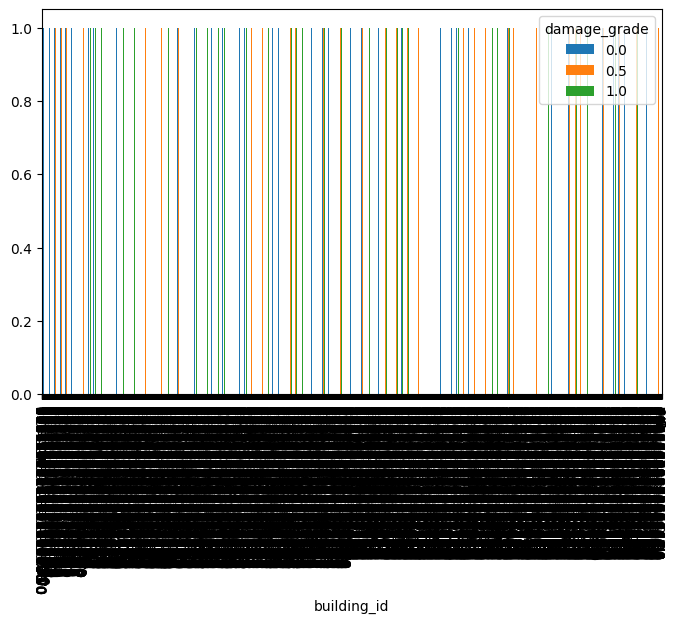

In [ ]:
plot('building_id')

<Axes: xlabel='geo_level_1_id'>

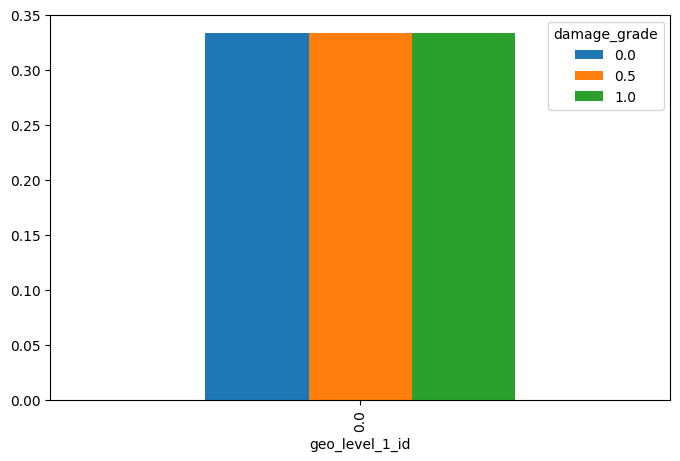

In [ ]:
plot('geo_level_1_id')

<Axes: xlabel='geo_level_2_id'>

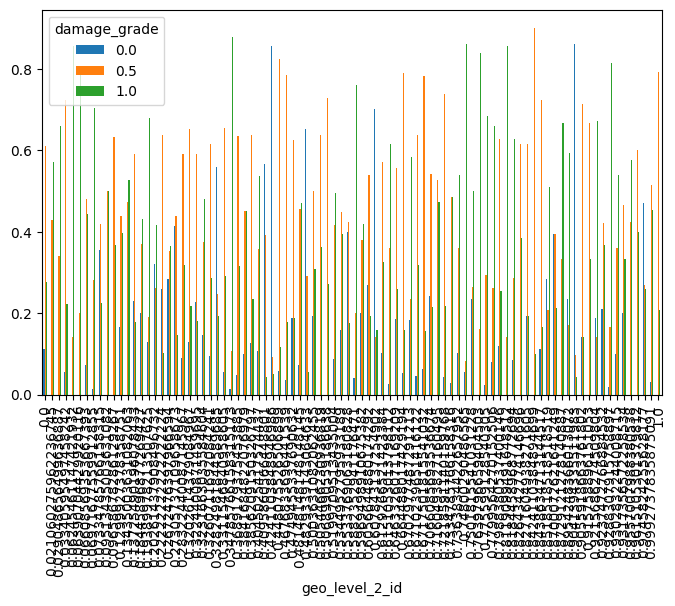

In [ ]:
plot('geo_level_2_id')

<Axes: xlabel='geo_level_3_id'>

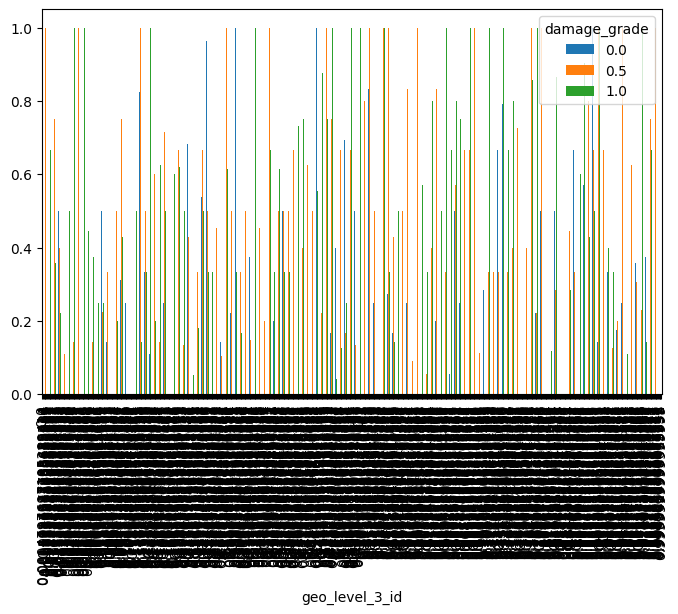

In [ ]:
plot('geo_level_3_id')

<Axes: xlabel='count_floors_pre_eq'>

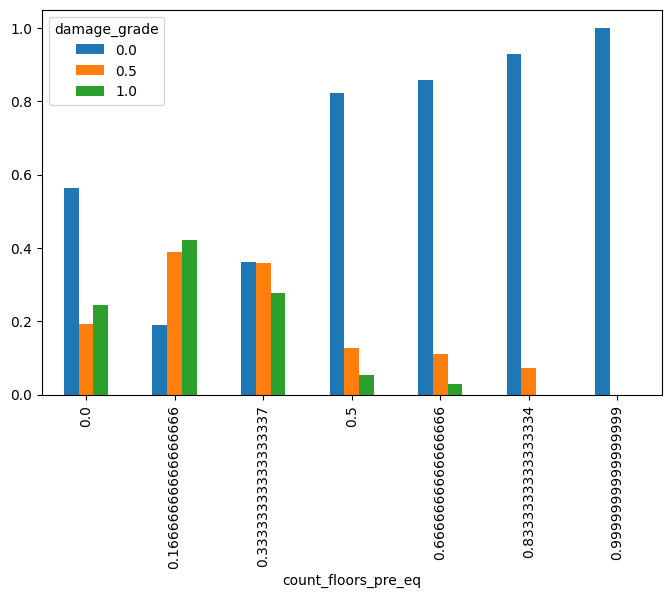

In [ ]:
plot('count_floors_pre_eq')

<Axes: xlabel='age'>

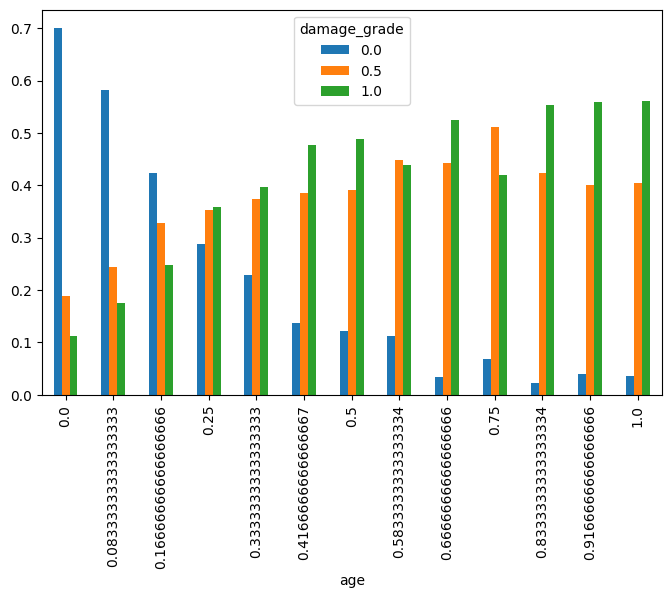

In [ ]:
plot('age')

<Axes: xlabel='area_percentage'>

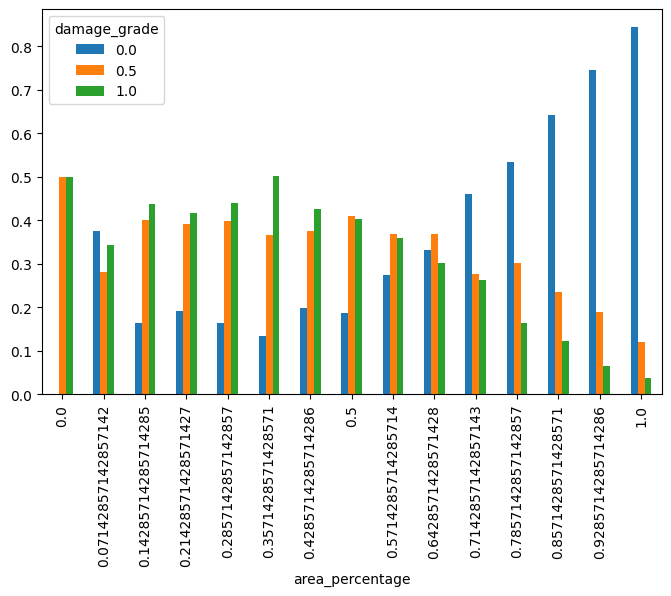

In [ ]:
plot('area_percentage')

<Axes: xlabel='height_percentage'>

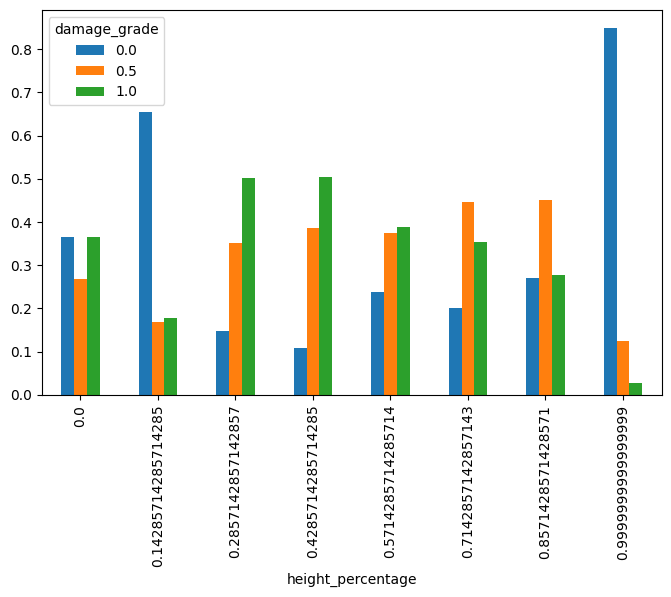

In [ ]:
plot('height_percentage')

<Axes: xlabel='land_surface_condition'>

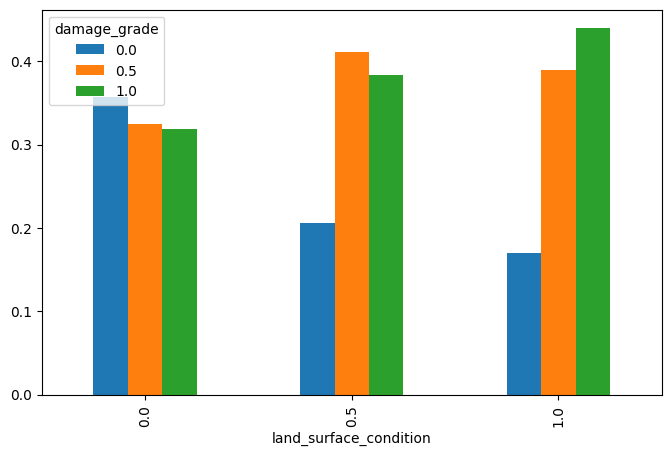

In [ ]:
plot('land_surface_condition')

<Axes: xlabel='foundation_type'>

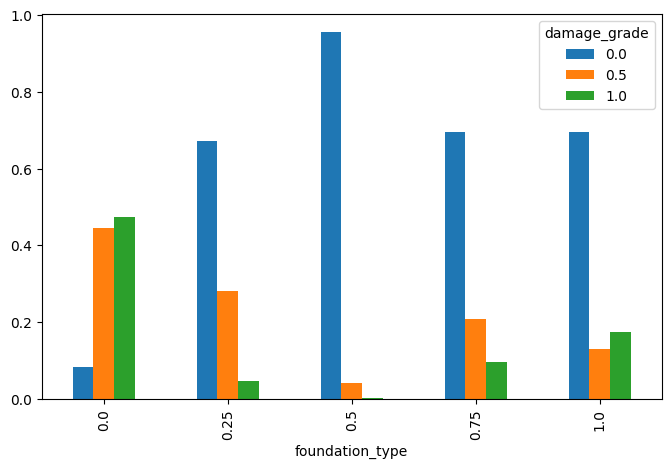

In [ ]:
plot('foundation_type')

<Axes: xlabel='roof_type'>

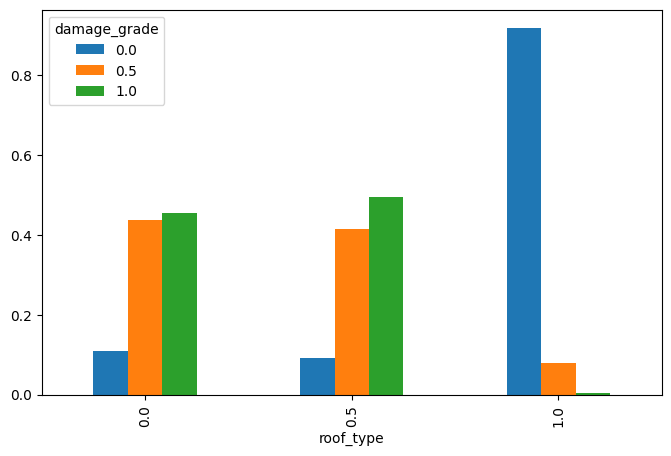

In [ ]:
plot('roof_type')

<Axes: xlabel='ground_floor_type'>

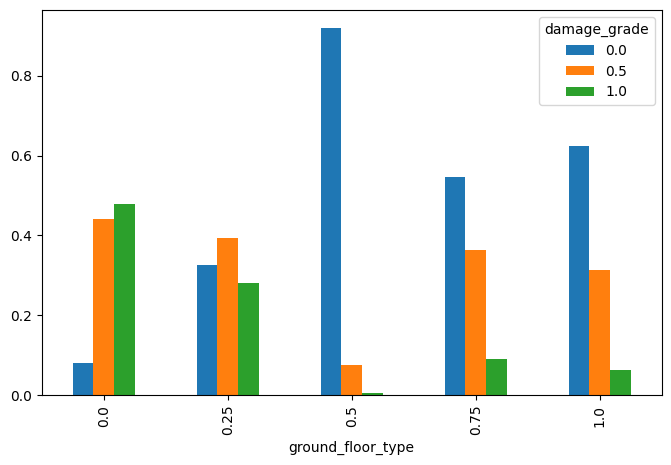

In [ ]:
plot('ground_floor_type')

<Axes: xlabel='other_floor_type'>

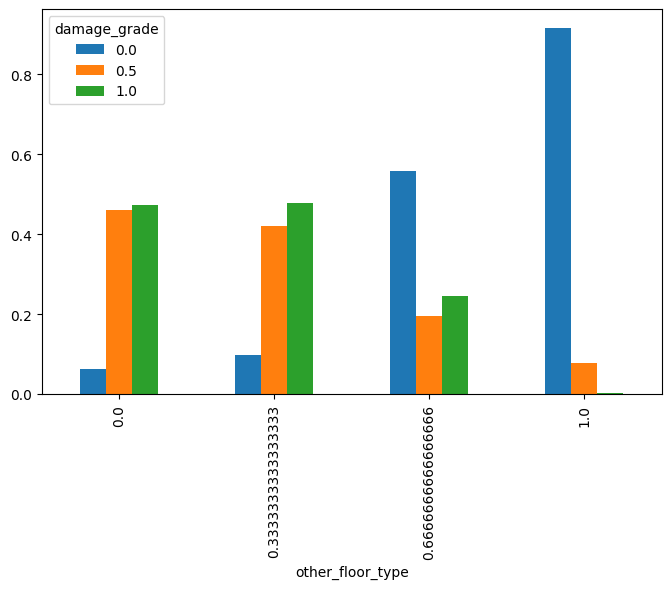

In [ ]:
plot('other_floor_type')

<Axes: xlabel='position'>

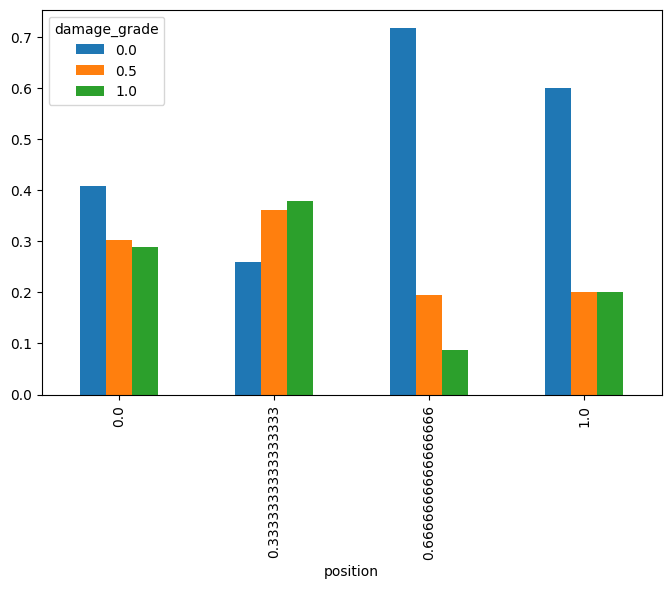

In [ ]:
plot('position')

<Axes: xlabel='plan_configuration'>

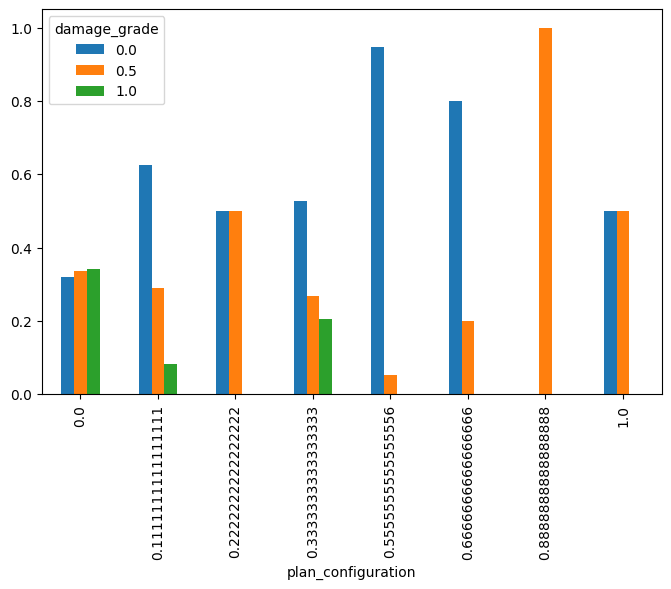

In [ ]:
plot('plan_configuration')

<Axes: xlabel='has_superstructure_adobe_mud'>

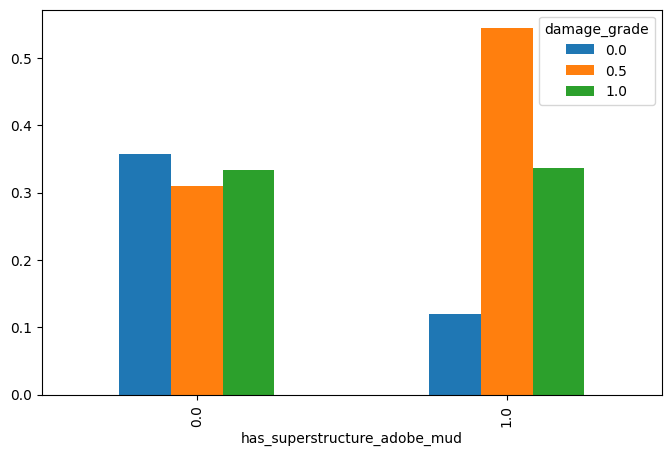

In [ ]:
plot('has_superstructure_adobe_mud')

<Axes: xlabel='has_superstructure_mud_mortar_stone'>

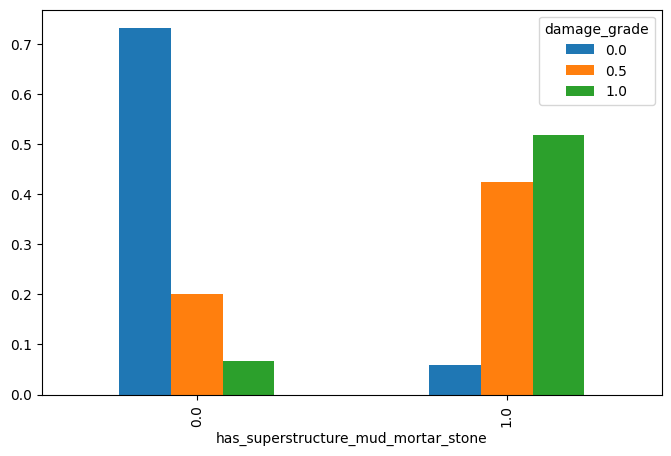

In [ ]:
plot('has_superstructure_mud_mortar_stone')

<Axes: xlabel='has_superstructure_stone_flag'>

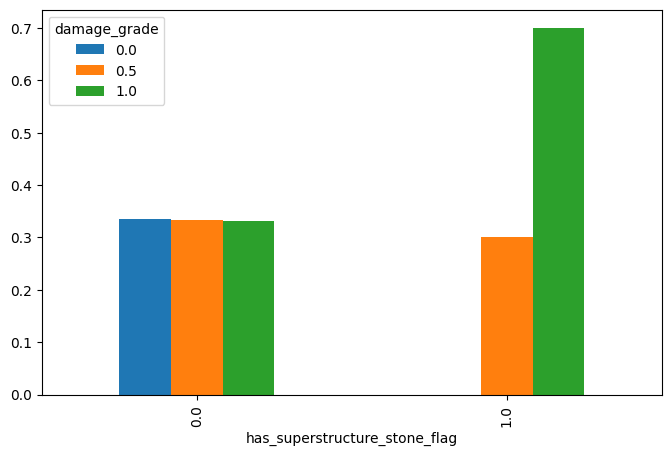

In [ ]:
plot('has_superstructure_stone_flag')

<Axes: xlabel='has_superstructure_cement_mortar_stone'>

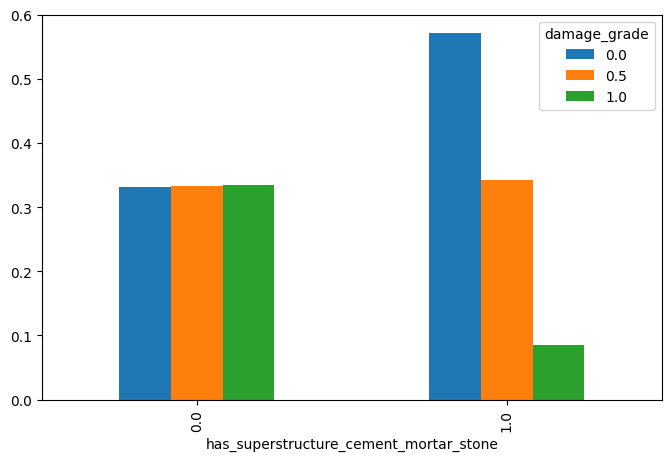

In [ ]:
plot('has_superstructure_cement_mortar_stone')

<Axes: xlabel='has_superstructure_mud_mortar_brick'>

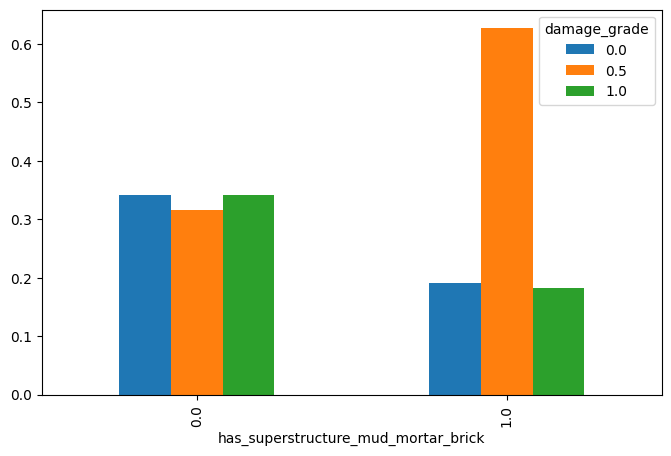

In [ ]:
plot('has_superstructure_mud_mortar_brick')

<Axes: xlabel='has_superstructure_cement_mortar_brick'>

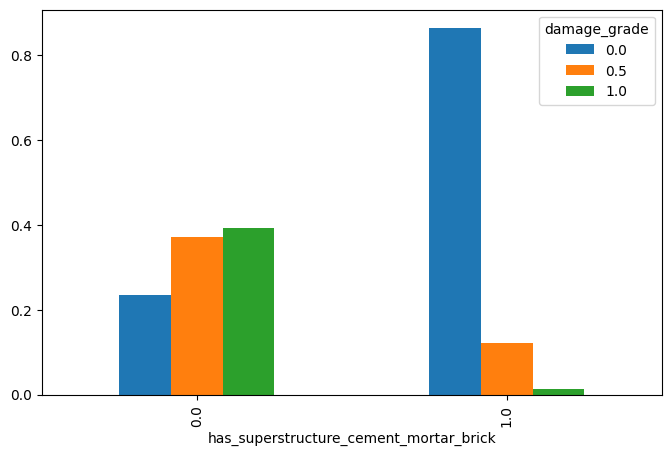

In [ ]:
plot('has_superstructure_cement_mortar_brick')

<Axes: xlabel='has_superstructure_timber'>

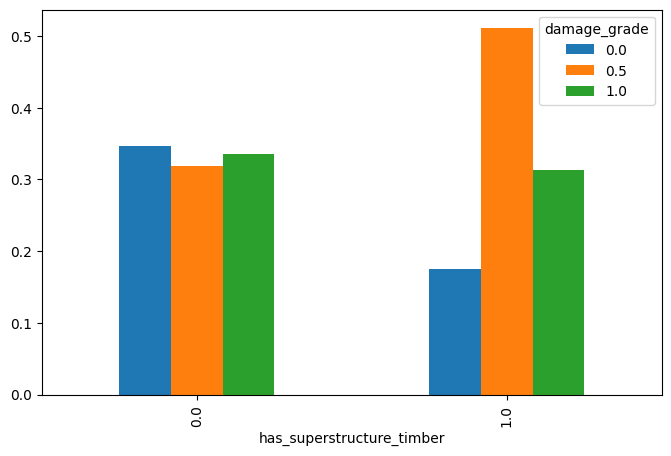

In [ ]:
plot('has_superstructure_timber')

<Axes: xlabel='has_superstructure_bamboo'>

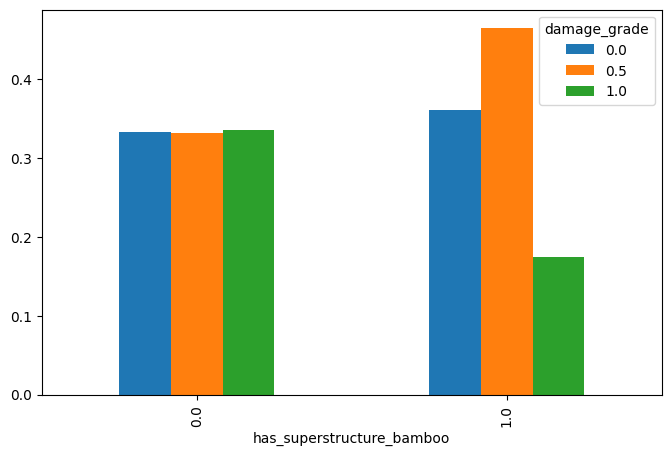

In [ ]:
plot('has_superstructure_bamboo')

<Axes: xlabel='has_superstructure_rc_non_engineered'>

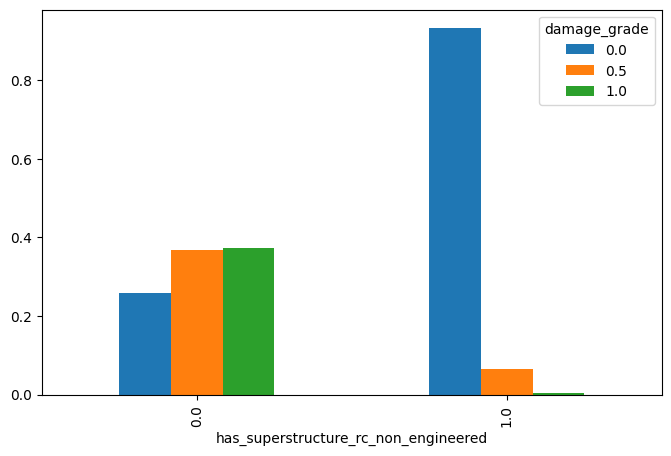

In [ ]:
plot('has_superstructure_rc_non_engineered')

<Axes: xlabel='has_superstructure_rc_engineered'>

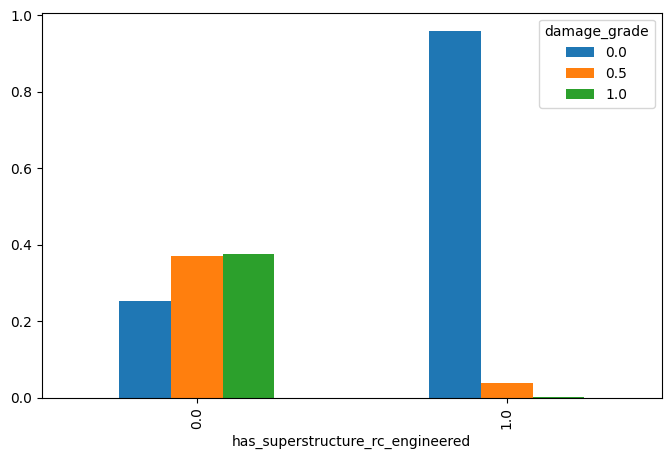

In [ ]:
plot('has_superstructure_rc_engineered')

<Axes: xlabel='has_superstructure_other'>

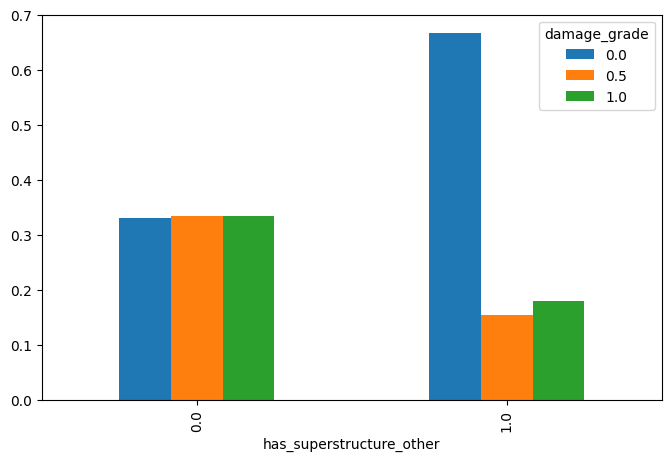

In [ ]:
plot('has_superstructure_other')

<Axes: xlabel='legal_ownership_status'>

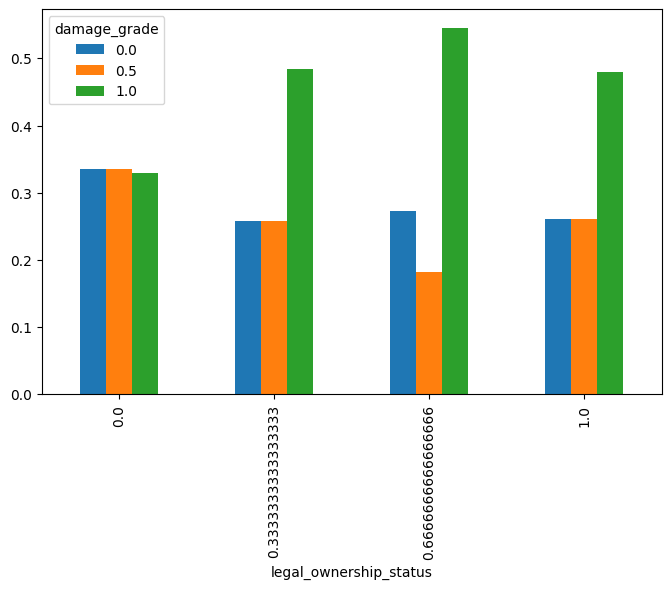

In [ ]:
plot('legal_ownership_status')

<Axes: xlabel='count_families'>

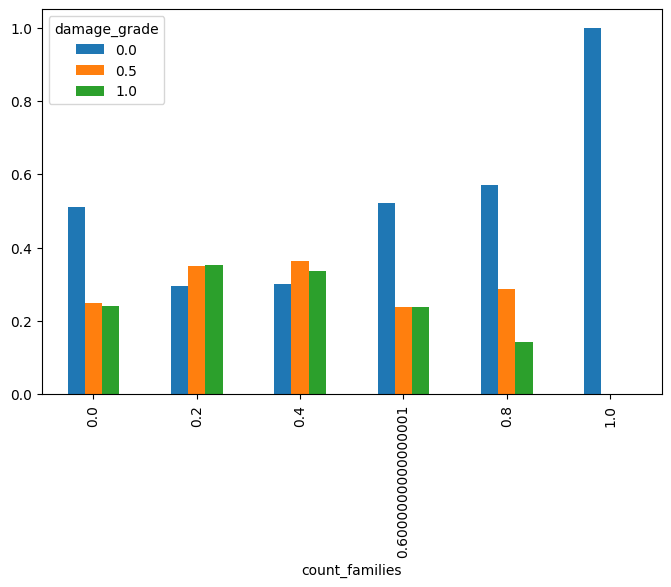

In [ ]:
plot('count_families')

<Axes: xlabel='has_secondary_use'>

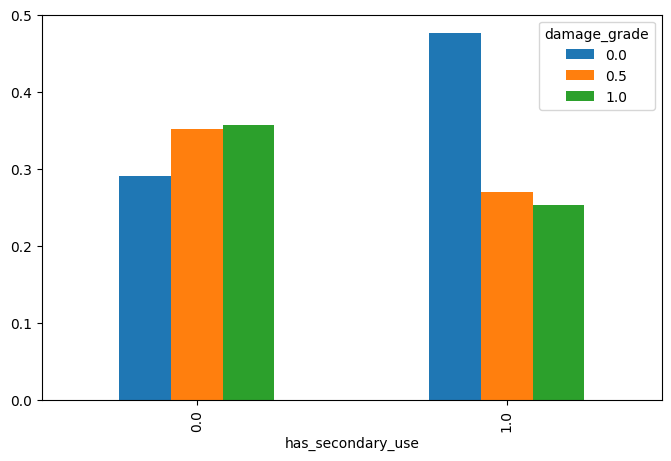

In [ ]:
plot('has_secondary_use')

<Axes: xlabel='has_secondary_use_agriculture'>

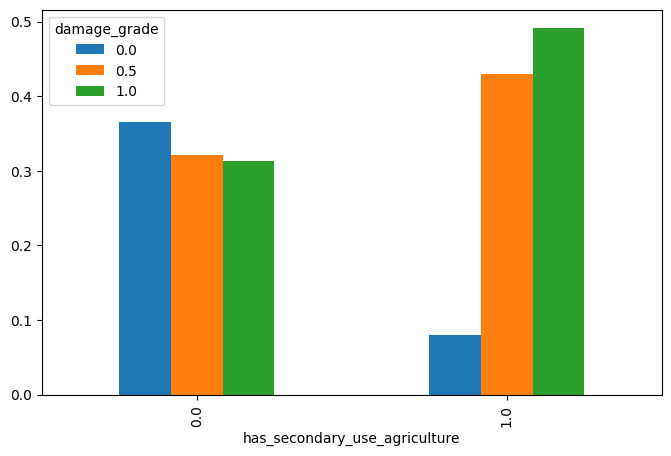

In [ ]:
plot('has_secondary_use_agriculture')

<Axes: xlabel='has_secondary_use_hotel'>

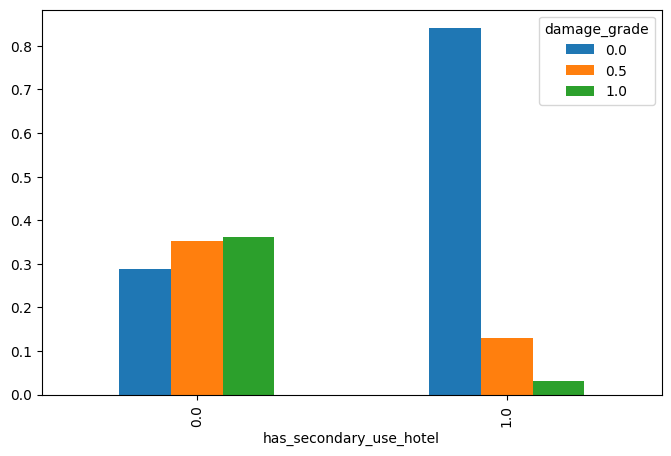

In [ ]:
plot('has_secondary_use_hotel')

<Axes: xlabel='has_secondary_use_rental'>

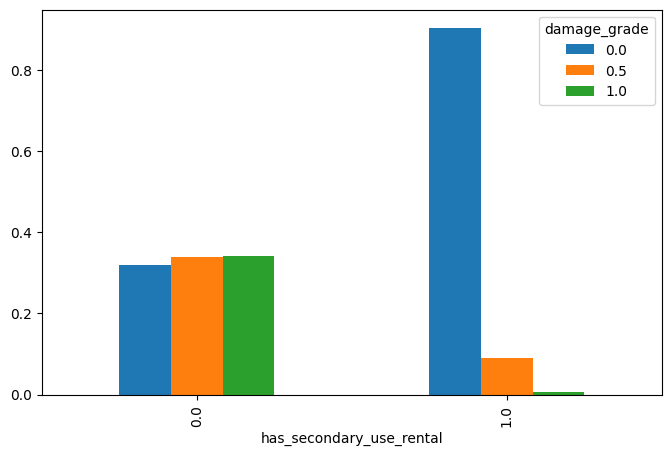

In [ ]:
plot('has_secondary_use_rental')

<Axes: xlabel='has_secondary_use_institution'>

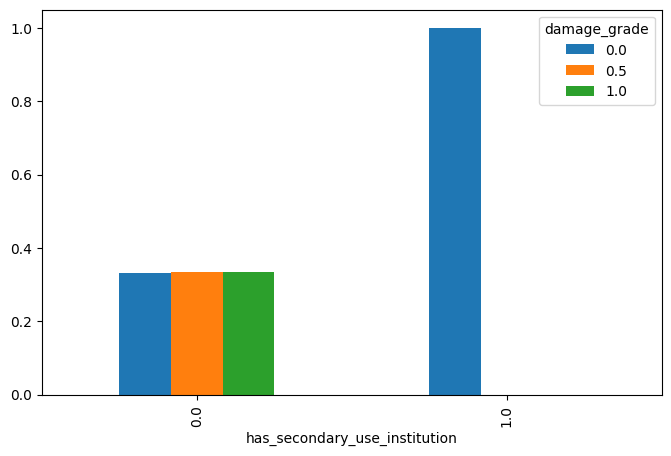

In [ ]:
plot('has_secondary_use_institution')

<Axes: xlabel='has_secondary_use_school'>

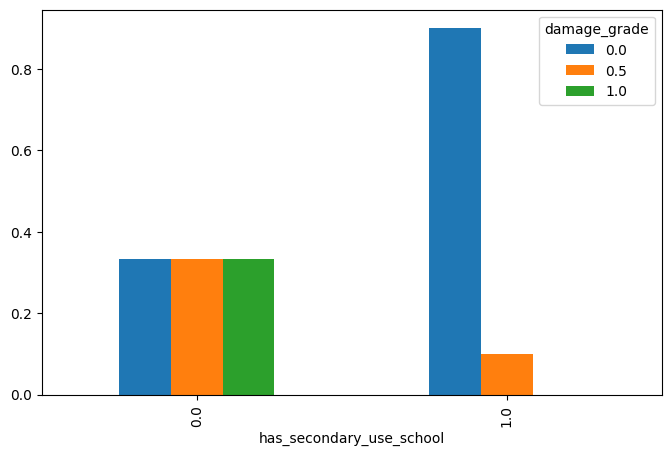

In [ ]:
plot('has_secondary_use_school')

<Axes: xlabel='has_secondary_use_industry'>

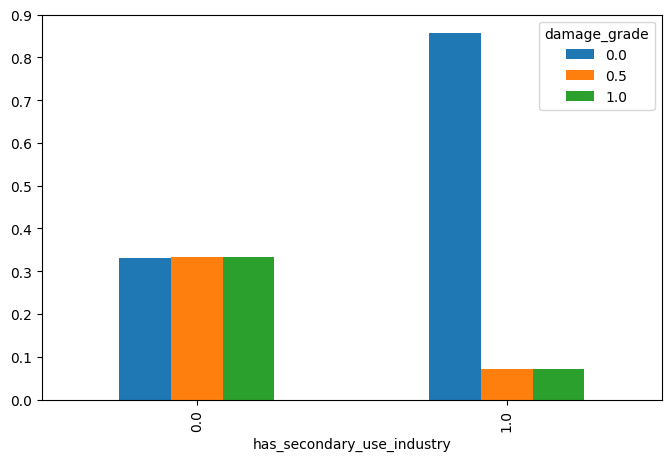

In [ ]:
plot('has_secondary_use_industry')

<Axes: xlabel='has_secondary_use_health_post'>

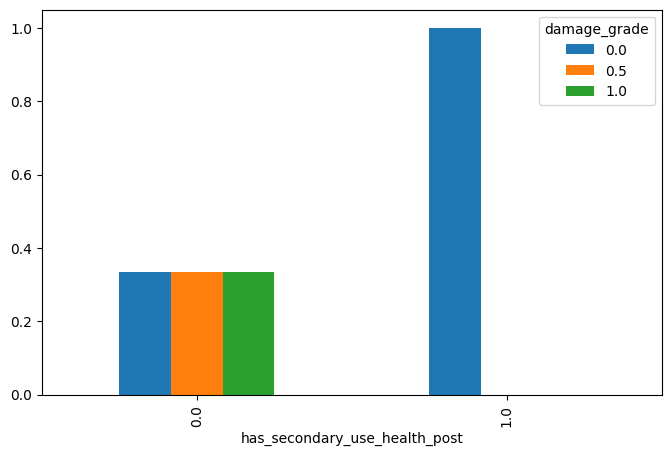

In [ ]:
plot('has_secondary_use_health_post')

<Axes: xlabel='has_secondary_use_gov_office'>

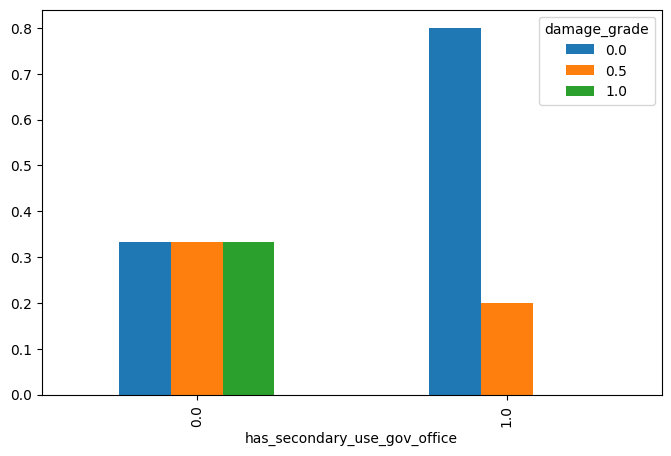

In [ ]:
plot('has_secondary_use_gov_office')

<Axes: xlabel='has_secondary_use_use_police'>

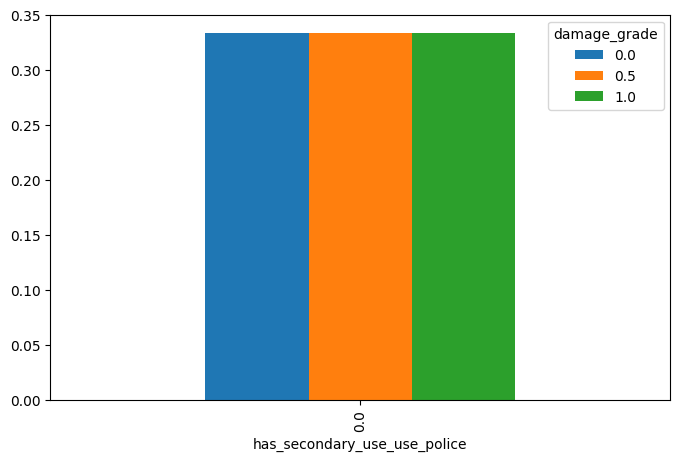

In [ ]:
plot('has_secondary_use_use_police')

<Axes: xlabel='has_secondary_use_other'>

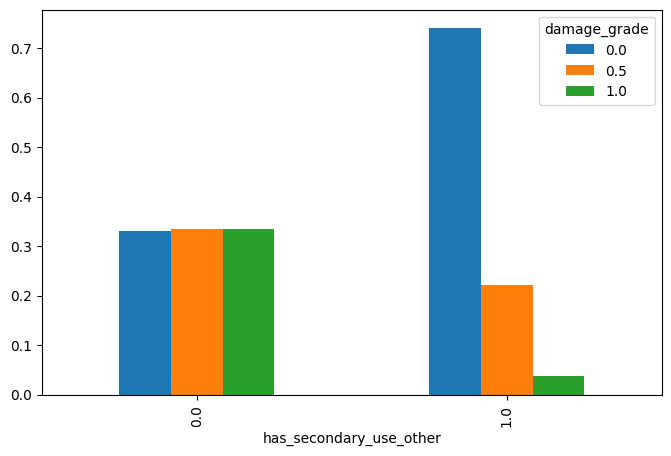

In [ ]:
plot('has_secondary_use_other')

A partir de las visualizaciones, está claro que en el conjunto de datos dado, las características 'building_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'position', 'plan_configuration', 'legal_ownership_status', 'count_families' y 'has_secondary_use_agriculture' no tienen mucha relación con la variable objetivo 'damage_grade' así que las eliminamos.

In [ ]:
df_estudio_train = df_train_sp.drop(columns=['building_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'position', 'plan_configuration', 'legal_ownership_status','count_families', 'has_secondary_use_agriculture'])


In [ ]:
df_estudio_val  = df_valid_sp.drop(columns=['building_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'position', 'plan_configuration', 'legal_ownership_status','count_families', 'has_secondary_use_agriculture'])

In [ ]:
df_estudio_test  = df_test_scaled.drop(columns=['building_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'position', 'plan_configuration', 'legal_ownership_status','count_families', 'has_secondary_use_agriculture'])

## **Dendograma**

Distancia Media	  27.88


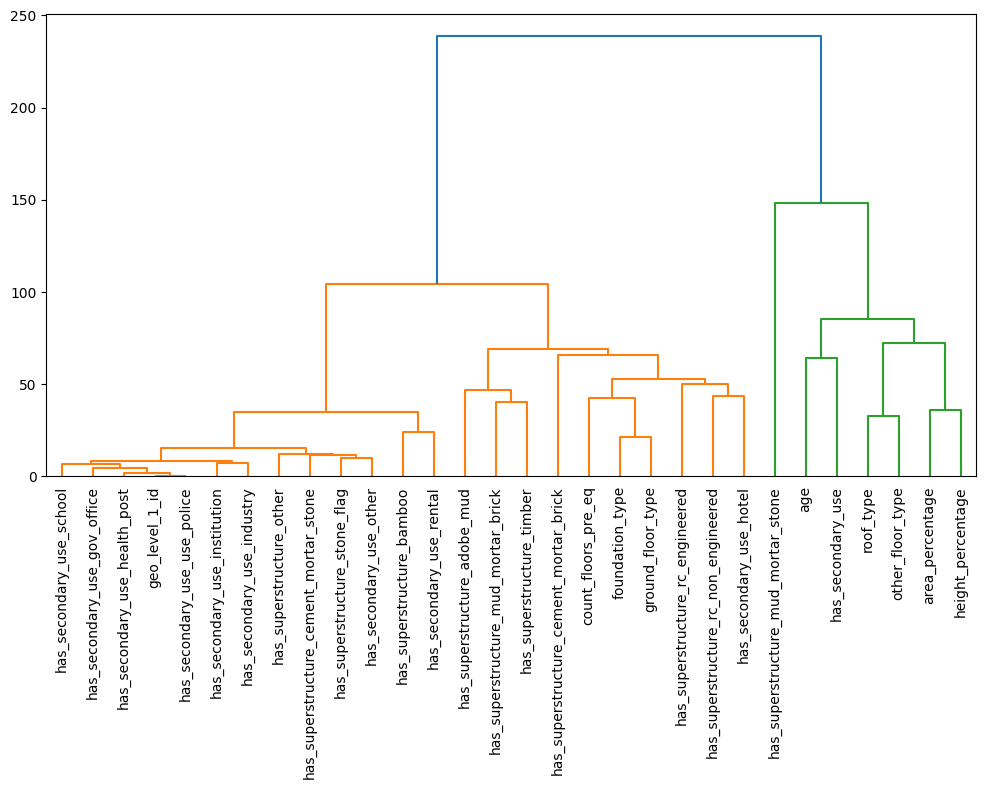

In [ ]:
# Obtenemos la matriz de distancia entre todos los elementos

dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(df_estudio_train.drop('damage_grade', axis=1).T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# Construimos el dendograma
from scipy import cluster
plt.figure(figsize=(12, 6))

# Seleccionamos como distancia intercluster el vecino más alejado (complete)
clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=160,labels=df_estudio_train.drop('damage_grade', axis=1).columns.to_list(),leaf_rotation=90)

plt.show()

In [ ]:
# Obtenemos el cluster al que pertenece cada fila del dataset
threshold = 160 # ad-hoc
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')

# Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels


Número de clusters 2


array([1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

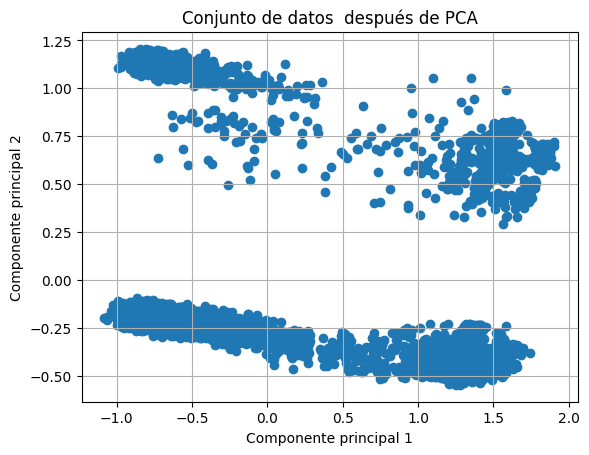

In [ ]:
# Las columnas se agrupan en 4 clusteres y aplicamos PCA

from sklearn.decomposition import PCA
import numpy as np

# Reducimos los datos a dos dimensiones

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_train_sp)


plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("Conjunto de datos  después de PCA")
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid(True)
plt.show()

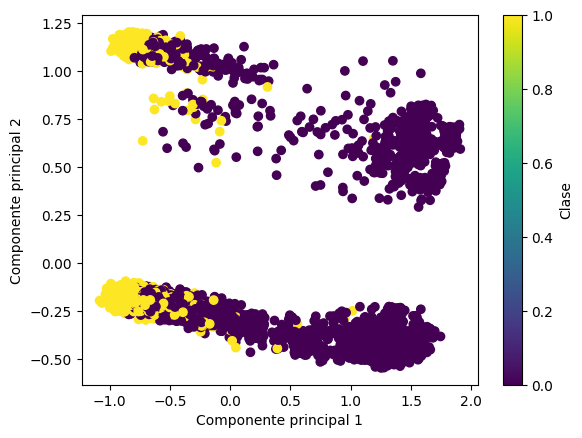

In [ ]:
# Visualizamos los datos en el nuevo espacio de características PCA
y_pca = df_train_sp['damage_grade'].astype('int')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, cmap='viridis')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(label='Clase')
plt.show()

## **Matriz de Correlación**

<Axes: >

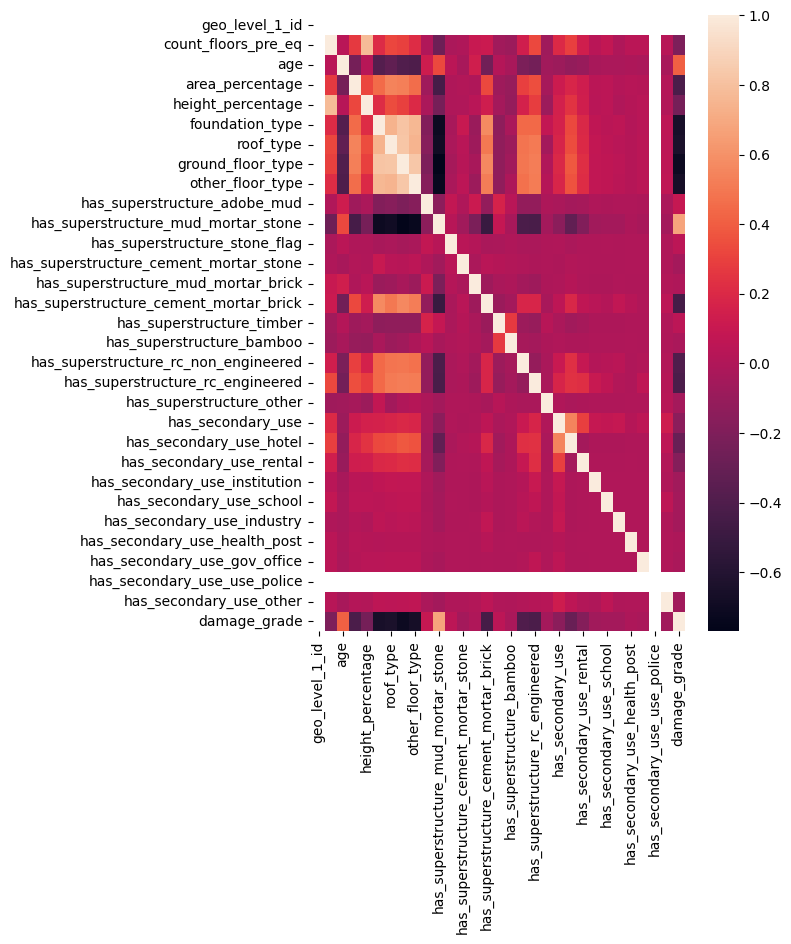

In [ ]:
plt.rcParams["figure.figsize"] = (6,8)
sns.heatmap(df_estudio_train.corr())

## **Mapa de calor de correlación**

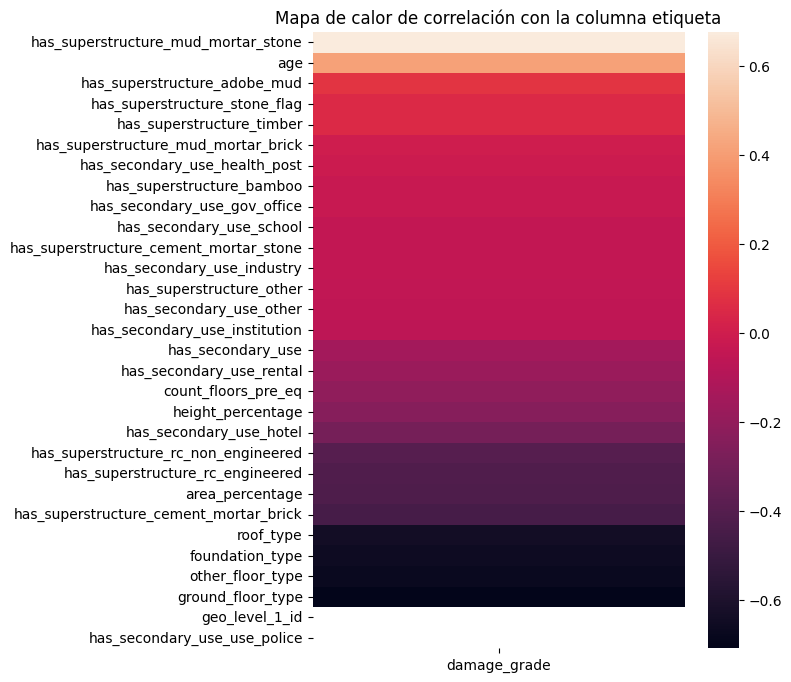

In [ ]:
DEPOSIT_COLUMN = 'damage_grade'
correlation_matrix = df_estudio_train.corr()
def plot_deposit_correlations(data):

    deposit_correlation_column = pd.DataFrame(correlation_matrix[DEPOSIT_COLUMN].drop(DEPOSIT_COLUMN))
    deposit_correlation_column = deposit_correlation_column.sort_values(by=DEPOSIT_COLUMN, ascending=False)
    sns.heatmap(deposit_correlation_column)
    plt.title('Mapa de calor de correlación con la columna etiqueta')

plot_deposit_correlations(df_estudio_train)

## **Logistic Regression**

In [ ]:
# Tras observar la matriz de correlación volvemos a borrar columnas poco significativas
X_train = df_estudio_train.drop(columns=['damage_grade','has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_health_post'])
y_train = df_estudio_train['damage_grade'].replace({0.0:1,0.5 :2, 1.0:3})
X_val   = df_estudio_val.drop(columns=['damage_grade','has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_health_post'])
y_val   = df_estudio_val['damage_grade'].replace({0.0:1,0.5 :2, 1.0:3})
X_test  = df_estudio_test.drop(columns=['has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_health_post'])
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(X_train , y_train)

LogisticRegression(max_iter=10000)

In [ ]:
print(model_lr.coef_)  # coeficientes de regresión

[[ 0.         -1.28492256 -1.66500661  0.12295638  0.83382471  0.54374983
   0.37468338  0.97916403  0.78855178 -0.22385422 -0.94417044 -0.55573423
   0.01537089 -0.09033971  0.46640722  0.20873993  0.50150079  0.9938978
   1.17202127  0.82502151 -0.1031526   0.42972395  0.32222025  0.40790879
   0.00244883  0.66462929  0.4878155 ]
 [ 0.          0.11703396  0.45309201  0.1511936   0.32617957 -0.25347243
  -0.28100693 -0.1290013  -0.3945328   0.25794693  0.23443012 -0.1391329
   0.40107662  0.54820034  0.46373382  0.1134024   0.10570883  0.15808331
  -0.01292675 -0.53490498  0.03020605 -0.0184026   0.08656754 -0.36040743
   0.06554009 -0.59167633  0.21143111]
 [ 0.          1.16788861  1.2119146  -0.27414998 -1.16000428 -0.2902774
  -0.09367645 -0.85016273 -0.39401899 -0.03409271  0.70974032  0.69486713
  -0.41644751 -0.45786063 -0.93014104 -0.32214233 -0.60720962 -1.1519811
  -1.15909452 -0.29011653  0.07294655 -0.41132135 -0.40878779 -0.04750137
  -0.06798892 -0.07295296 -0.69924661]

In [ ]:
# Evaluamos el modelo de regresión logística
preds_train = model_lr.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_train, average='micro'))

F1_score del modelo en validation: 0.665086887835703


In [ ]:
y_pred_lr = model_lr.predict(X_test)
np.unique(y_pred_lr)

array([1., 2., 3.])

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          titleSup=None):
    # y_true : dataframe -> Los valores de las clases que son ciertos (test)
    # y_pred : ndarray   -> Los valores calculados de las clases después de realizar la predicción
    # class  : ndarray   -> Los nombres de las clases/valores objetivos

    if not title:
        if normalize:
            title = 'Matriz de Confusión normalizada'
        else:
            title = 'Matriz de Confusión, no normalizada'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(type(y_true))
    print(type(y_pred))
    classes = classes[unique_labels(y_true.astype(int), y_pred.astype(int))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión normalizada")
    else:
        print('Matriz de Confusión, no normalizada')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.suptitle(titleSup, fontsize=16, y=1, ha='center')
    return ax

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[1626  178   93]
 [ 153  833  911]
 [  17  488 1392]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.85714286 0.09383237 0.04902478]
 [0.08065366 0.43911439 0.48023195]
 [0.00896152 0.25724829 0.7337902 ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

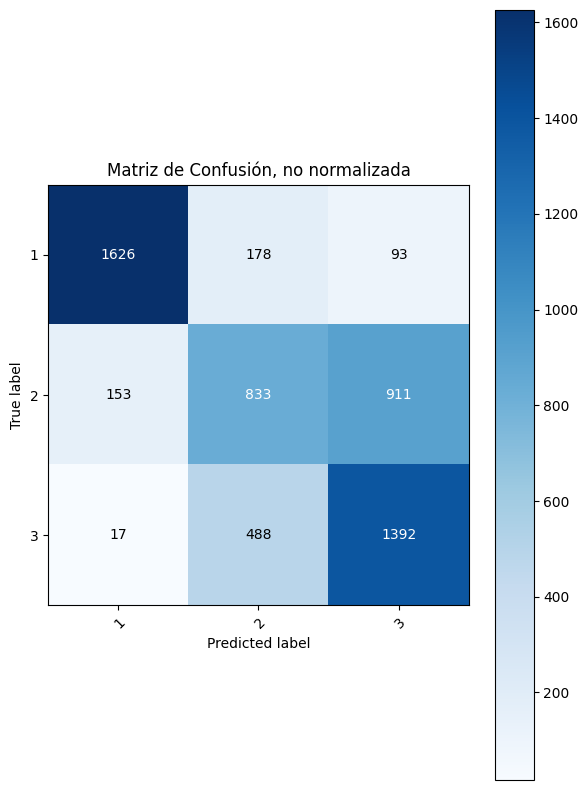

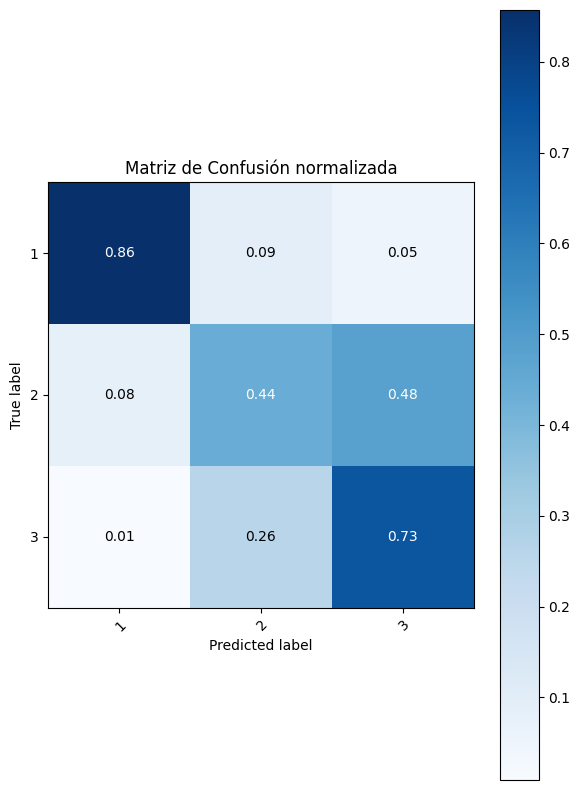

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model_lr.predict(X_train)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(y_train, y_pred,classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_train, y_pred,classes= np.array(['0','1','2','3']) , normalize=True)

A continuación, creamos un método para descargar ficheros con el formato de submission del reto de driven data.

In [ ]:
def guardar_predicciones_como_csv(y_pred, nombre_fichero):
    # Crear una copia del DataFrame de envío
    submit = df_submission.copy()

    # Redondear las predicciones y convertirlas a tipo entero
    predicciones_redondeadas = np.round(y_pred).astype(int)

    # Asignar las predicciones redondeadas a la columna 'damage_grade'
    submit['damage_grade'] = predicciones_redondeadas

    # Guardar el DataFrame modificado como un archivo CSV sin el índice
    submit.to_csv(nombre_fichero, index=False)

    # Descargar el archivo CSV
    try:
        from google.colab import files
        files.download(nombre_fichero)
    except ImportError:
        print(f"Descarga manualmente el archivo desde: {nombre_fichero}")

In [ ]:
guardar_predicciones_como_csv(y_pred_lr,'preds_lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Linear Regression Con Cross Validation**

In [ ]:
X_train_cv= X_train.copy() # Hacemos copia del dataset porque shuffle =True desordena el dataset
y_train_cv= y_train.copy()

cv = KFold(n_splits = 20, shuffle = True)
cv_f1scores=[]

for i in range(2,10):
  for cv_train, cv_test in cv.split(X_train):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_cv.iloc[cv_train]
    cv_train_y = y_train_cv.iloc[cv_train]

    # Entrenamos los modelos
    model_lr.fit(cv_train_x, cv_train_y)

    # Guardamos el predict de cada modelo
    y_pred = model_lr.predict(X_train.iloc[cv_test])


    y_np=y_train.iloc[cv_test].values

    cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

    cv_f1scores.append(cv_f1score)

  # Guardamos la media de los f1_Scores, para cada split
  media_scores=sum(cv_f1scores)/len(cv_f1scores)

  # Recorremos los clasificadores y mostramos la precisión para cada uno de ellos
  print ("F1_Score medio: = %.4f para %i splits" %  (media_scores,i ))

F1_Score medio: = 0.6733 para 2 splits
F1_Score medio: = 0.6733 para 3 splits
F1_Score medio: = 0.6728 para 4 splits
F1_Score medio: = 0.6725 para 5 splits
F1_Score medio: = 0.6726 para 6 splits
F1_Score medio: = 0.6724 para 7 splits
F1_Score medio: = 0.6727 para 8 splits
F1_Score medio: = 0.6726 para 9 splits


In [ ]:
X_train_cv= X_train.copy()
y_train_cv= y_train.copy()
cv = KFold(n_splits = 8, shuffle = True)
cv_f1scores=[]

for cv_train, cv_test in cv.split(X_train):
  cv_train_x = X_train_cv.iloc[cv_train]
  cv_train_y = y_train_cv.iloc[cv_train]


  model_lr.fit(cv_train_x, cv_train_y)


  y_pred = model_lr.predict(X_train.iloc[cv_test])

  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)

# Guardamos la media de los f1_Scores, para cada split
media_scores=sum(cv_f1scores)/len(cv_f1scores)

# Recorremos los clasificadores y mostramos la media
print ("F1_Score medio: = %.4f" %  (media_scores ))

F1_Score medio: = 0.6718


Hacemos la predicción del modelo entrenado con cross validation sobre test

In [ ]:
y_pred_lr = model_lr.predict(X_test)

In [ ]:
guardar_predicciones_como_csv(y_pred_lr,'lr_cv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Estimación de los mejores hiperparámetros con GridSearch**

In [ ]:
# Definir rango de parámetros

parametros = {
    'class_weight' : ['None','balanced'],
    'fit_intercept': [True, False],
    'multi_class'  : ['ovr', 'multinomial'],
    'penalty'      : ['l1','l2']
}

# Cross Validation
cv = KFold(n_splits=8, shuffle=True, random_state=42) # Usamos el número de splits obtenido anteriormente

# GridSearch
GS_lr = GridSearchCV(model_lr, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_lr.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = GS_lr.best_params_
print(mejores_params)

{'class_weight': 'balanced', 'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2'}


In [ ]:
model_lr_gs = LogisticRegression(max_iter=10000, **mejores_params)
model_lr_gs.fit(X_train , y_train)


LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=10000,
                   multi_class='multinomial')

**Predicciones del modelo entrenado con las recomendaciones de Grid Search**

F1_score del modelo en validation: 0.6635071090047393
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[176  25  10]
 [  7  97 107]
 [  4  60 147]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.83412322 0.11848341 0.04739336]
 [0.03317536 0.45971564 0.507109  ]
 [0.01895735 0.28436019 0.69668246]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

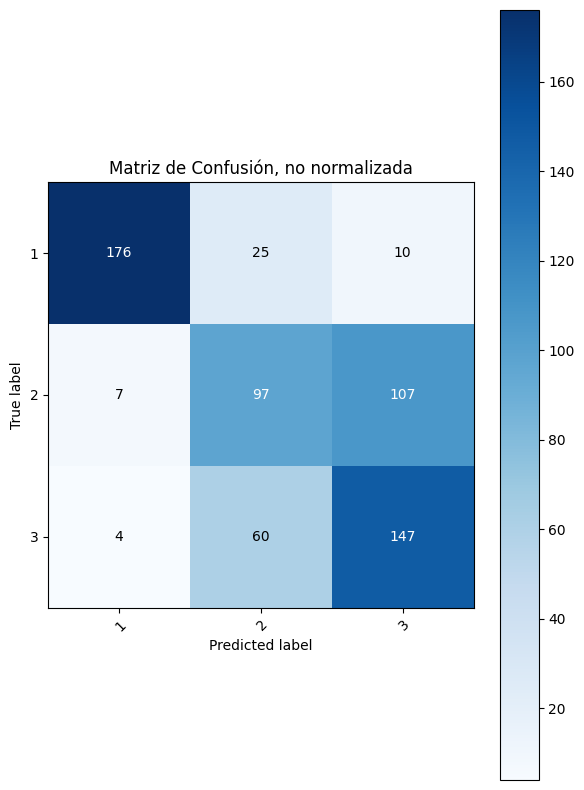

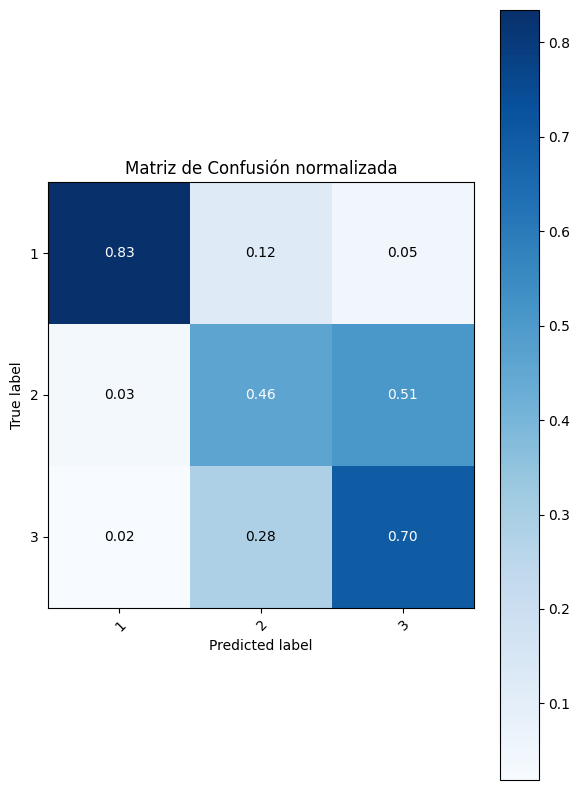

In [ ]:
preds_val = model_lr_gs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, preds_val)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=True)

In [ ]:
y_pred= model_lr_gs.predict(X_test)

In [ ]:
guardar_predicciones_como_csv(y_pred,'lr_GS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Aplicación de Random Search a Logistic Regression**

In [ ]:
# Definir rand de parámetros
parametros = {
    'class_weight' : ['None','balanced'],
    'fit_intercept': [True, False],
    'multi_class'  : ['ovr', 'multinomial'],
    'penalty'      : ['l1','l2']
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
RS_lr = RandomizedSearchCV(model_lr, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_lr.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = RS_lr.best_params_
print(mejores_params)

{'penalty': 'l2', 'multi_class': 'multinomial', 'fit_intercept': False, 'class_weight': 'balanced'}


F1_score del modelo en validation: 0.6635071090047393
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[176  25  10]
 [  7  97 107]
 [  4  60 147]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.83412322 0.11848341 0.04739336]
 [0.03317536 0.45971564 0.507109  ]
 [0.01895735 0.28436019 0.69668246]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

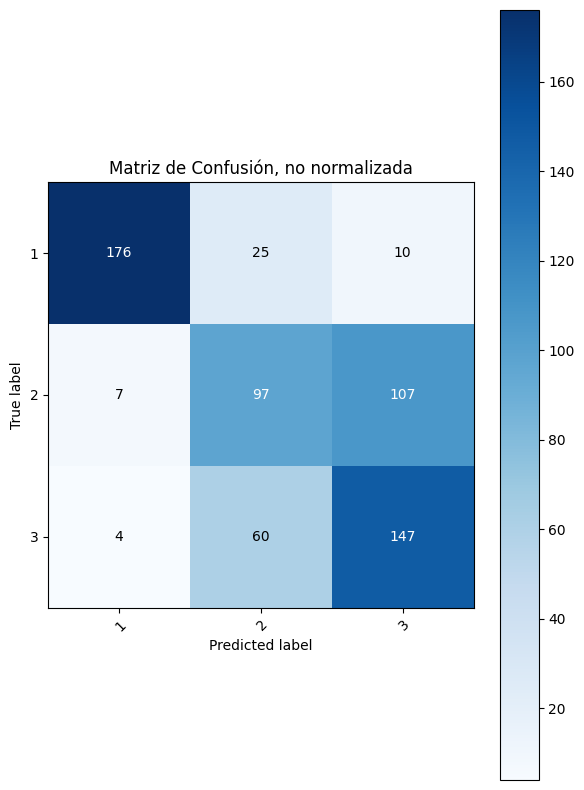

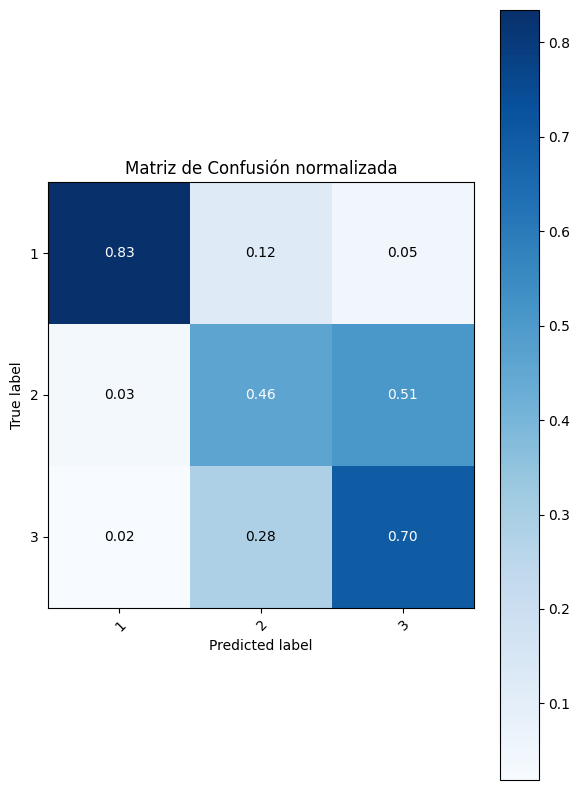

In [ ]:
model_lr_rs = LogisticRegression(max_iter=10000, **mejores_params)
model_lr_rs.fit(X_train , y_train)
preds_val = model_lr_rs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, preds_val)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, preds_val,classes= np.array(['0','1','2','3']) , normalize=True)

In [ ]:
y_pred= model_lr_rs.predict(X_test)

In [ ]:
guardar_predicciones_como_csv(y_pred,'lr_RS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **SVM - Máquina de Vector de Soporte**

In [ ]:
model_svc = SVC(kernel='linear', C=10000)
model_svc.fit(X_train, y_train)

SVC(C=10000, kernel='linear')

In [ ]:
def evaluar_modelo (modelo):
  preds_val  = modelo.predict(X_val)
  preds_test = modelo.predict(X_test)

  print(classification_report(preds_val, y_val))
  print('Accuracy en validation:', metrics.accuracy_score(preds_val, y_val))
  print('F1_score en validation:', metrics.f1_score( y_val,preds_val, average='micro'))
  return preds_test, preds_val

In [ ]:
y_test , pred_val= evaluar_modelo (model_svc)

              precision    recall  f1-score   support

         1.0       0.83      0.94      0.88       186
         2.0       0.28      0.55      0.37       110
         3.0       0.82      0.52      0.64       337

    accuracy                           0.65       633
   macro avg       0.65      0.67      0.63       633
weighted avg       0.73      0.65      0.66       633

Accuracy en validation: 0.6461295418641391
F1_score en validation: 0.6461295418641391


<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[175  16  20]
 [  8  60 143]
 [  3  34 174]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.82938389 0.07582938 0.09478673]
 [0.03791469 0.28436019 0.67772512]
 [0.01421801 0.16113744 0.82464455]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

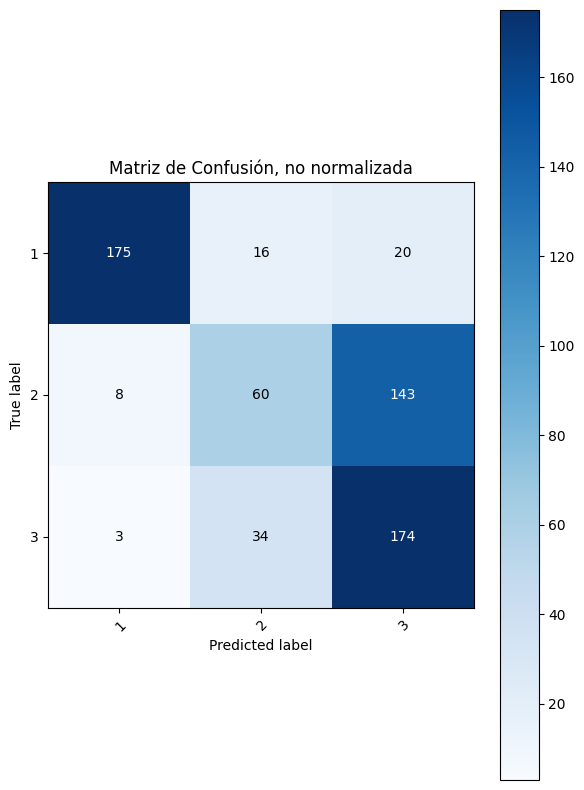

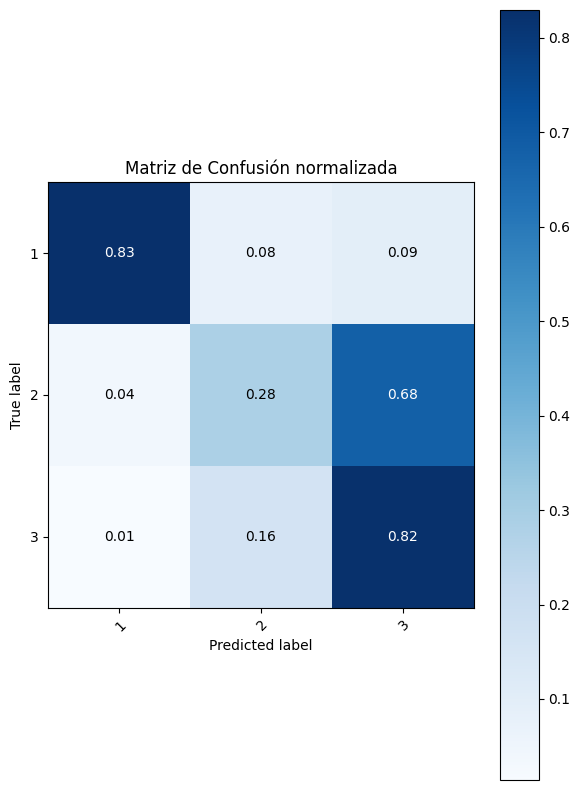

In [ ]:
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

In [ ]:
guardar_predicciones_como_csv(y_test,'SVC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **SVC con Cross Validation**

In [ ]:
X_val.head()

geo_level_1_id  count_floors_pre_eq  age  area_percentage  \
4628            0.00                 0.33 0.25             0.43   
492             0.00                 0.17 0.17             1.00   
2526            0.00                 0.33 0.42             0.43   
4889            0.00                 0.17 0.42             0.29   
4715            0.00                 0.33 0.50             0.57   

      height_percentage  foundation_type  roof_type  ground_floor_type  \
4628               0.43             0.00       0.00               0.00   
492                0.57             0.50       1.00               0.50   
2526               0.43             0.00       0.50               0.00   
4889               0.43             0.00       0.00               0.00   
4715               0.57             0.00       0.00               0.00   

      other_floor_type  has_superstructure_adobe_mud  ...  \
4628              0.00                          0.00  ...   
492               1.00                          0.00  ...   
2526              0.00                          0.00  ...   
4889              0.33                          1.00  ...   
4715              0.00                          0.00  ...   

      has_superstructure_rc_non_engineered  has_superstructure_rc_engineered  \
4628                                  0.00                              0.00   
492                                   0.00                              1.00   
2526                                  0.00                              0.00   
4889                                  0.00                              0.00   
4715                                  0.00                              0.00   

      has_superstructure_other  has_secondary_use  has_secondary_use_hotel  \
4628                      0.00               0.00                     0.00   
492                       0.00               0.00                     0.00   
2526                      0.00               0.00                     0.00   
4889                      0.00               1.00                     0.00   
4715                      0.00               0.00                     0.00   

      has_secondary_use_rental  has_secondary_use_institution  \
4628                      0.00                           0.00   
492                       0.00                           0.00   
2526                      0.00                           0.00   
4889                      0.00                           0.00   
4715                      0.00                           0.00   

      has_secondary_use_school  has_secondary_use_industry  \
4628                      0.00                        0.00   
492                       0.00                        0.00   
2526                      0.00                        0.00   
4889                      0.00                        0.00   
4715                      0.00                        0.00   

      has_secondary_use_other  
4628                     0.00  
492                      0.00  
2526                     0.00  
4889                     0.00  
4715                     0.00  

[5 rows x 27 columns]

In [ ]:
cv = KFold(n_splits = 8, shuffle = False)
cv_f1scores=[]

for cv_train, cv_test in cv.split(X_val):


  cv_train_x = X_val.iloc[cv_train]
  cv_train_y = y_train.iloc[cv_train]


  model_svc.fit(cv_train_x, cv_train_y)



  y_pred = model_svc.predict(X_val.iloc[cv_test])

  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)

media_scores=sum(cv_f1scores)/len(cv_f1scores)


print ("F1_Score medio: = %.4f " %  (media_scores ))

F1_Score medio: = 0.3474 


              precision    recall  f1-score   support

         1.0       0.24      0.34      0.28       151
         2.0       0.15      0.24      0.18       127
         3.0       0.70      0.41      0.52       355

    accuracy                           0.36       633
   macro avg       0.36      0.33      0.33       633
weighted avg       0.48      0.36      0.40       633

Accuracy en validation: 0.3617693522906793
F1_score en validation: 0.3617693522906793
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[ 51  71  89]
 [ 61  31 119]
 [ 39  25 147]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.24170616 0.33649289 0.42180095]
 [0.28909953 0.14691943 0.56398104]
 [0.18483412 0.11848341 0.69668246]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

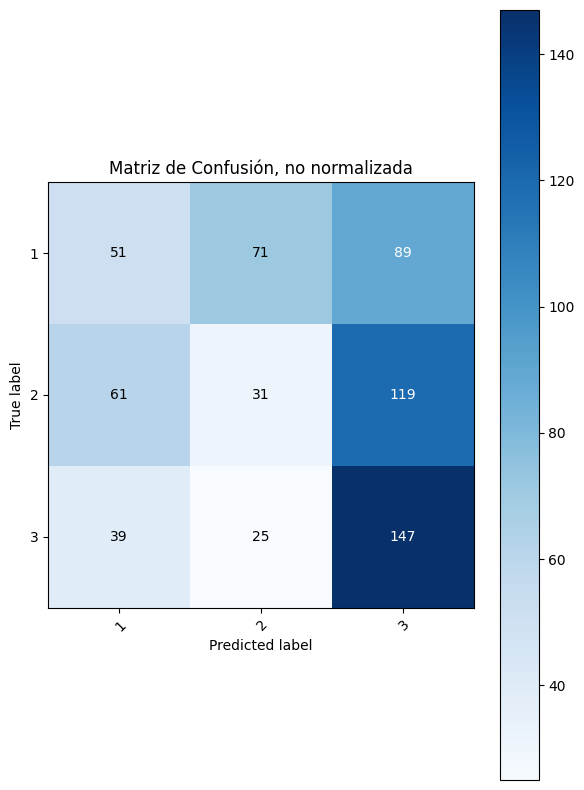

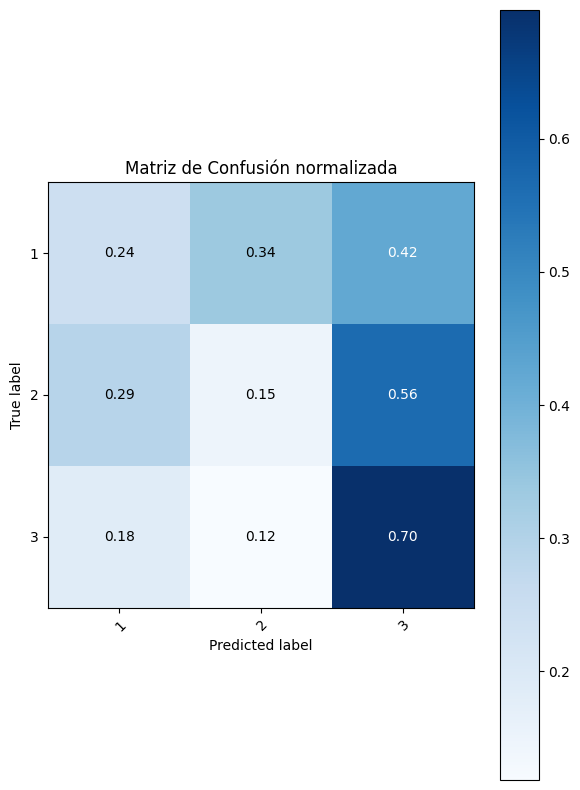

In [ ]:
y_test , pred_val= evaluar_modelo (model_svc)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

## **SVC con GridSearch**

In [ ]:
parametros = {
    'C'            : [0.5,5,10],
    'kernel'       : ['poly',  'rbf', 'sigmoid'],
    'class_weight' : ['None','balanced'],
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
GS_svc = GridSearchCV(model_svc, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_svc.fit(X_val, y_val)

# Obtener mejores parámetros
mejores_params = GS_svc.best_params_
print(mejores_params)

{'C': 5, 'class_weight': 'balanced', 'kernel': 'poly'}


In [ ]:
model_svc_gs = SVC(max_iter=10000, **mejores_params)
model_svc_gs.fit(X_train , y_train)
preds_val = model_svc_gs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

F1_score del modelo en validation: 0.6635071090047393


In [ ]:
y_pred= model_svc_gs.predict(X_test)

In [ ]:
guardar_predicciones_como_csv(y_pred,'SVC_GridSearch.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test , pred_val= evaluar_modelo (model_svc_gs)

              precision    recall  f1-score   support

         1.0       0.83      0.93      0.88       188
         2.0       0.41      0.55      0.47       156
         3.0       0.75      0.55      0.64       289

    accuracy                           0.66       633
   macro avg       0.66      0.68      0.66       633
weighted avg       0.69      0.66      0.67       633

Accuracy en validation: 0.6635071090047393
F1_score en validation: 0.6635071090047393


<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[175  21  15]
 [ 10  86 115]
 [  3  49 159]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.82938389 0.09952607 0.07109005]
 [0.04739336 0.40758294 0.5450237 ]
 [0.01421801 0.23222749 0.7535545 ]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

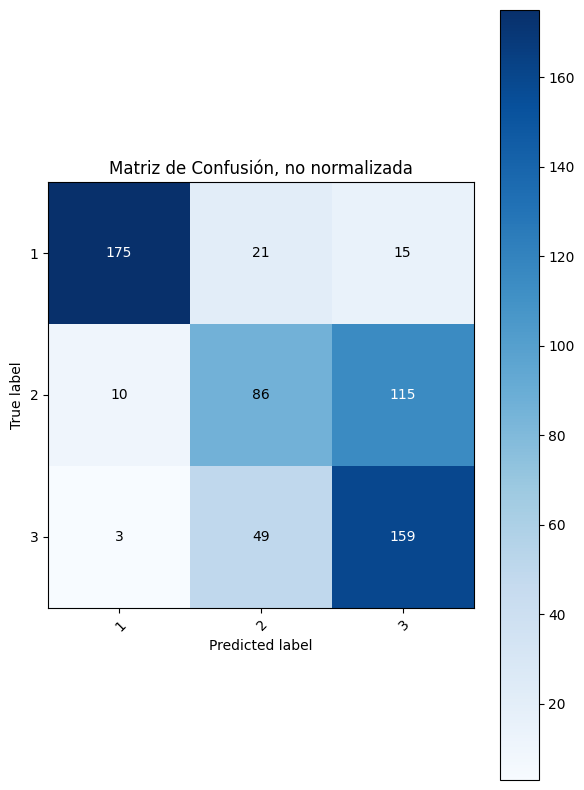

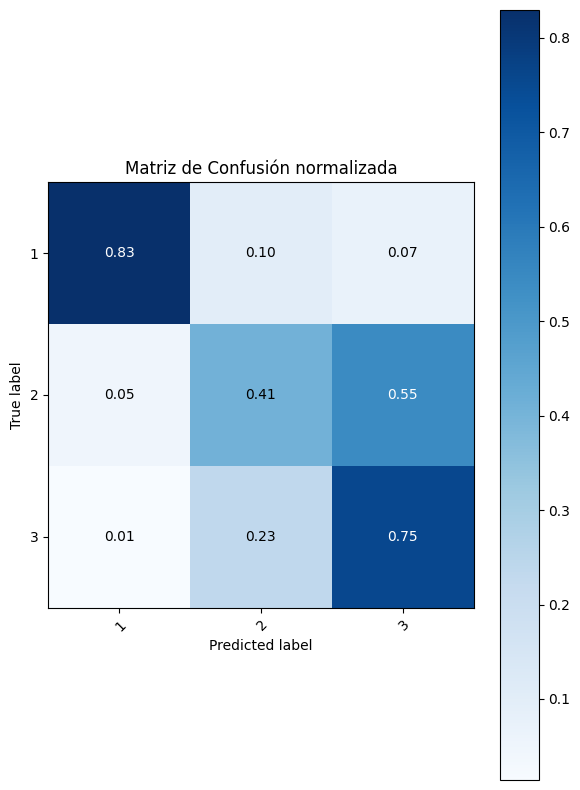

In [ ]:
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

## **SVC con Random Search**

In [ ]:
parametros = {
    'C'            : [0.5,5,10],
    'kernel'       : ['poly',  'rbf', 'sigmoid'],
    'class_weight' : ['None','balanced'],
}

# Cross Validation
cv = KFold(n_splits=20, shuffle=True, random_state=42) # Usamos el número de splits obtenido anteriormente

# GridSearch
RS_svc = RandomizedSearchCV(model_svc, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_svc.fit(X_val, y_val)

# Obtener mejores parámetros
mejores_params = GS_svc.best_params_
print(mejores_params)

{'C': 5, 'class_weight': 'balanced', 'kernel': 'poly'}


In [ ]:
model_svc_rs = SVC(max_iter=10000, **mejores_params)
model_svc_rs.fit(X_train , y_train)
preds_val = model_svc_rs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

F1_score del modelo en validation: 0.6635071090047393


## **Lazy Predict**

In [ ]:
lazy_model = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_model.fit(X_train, X_val, y_train, y_val)

print(models)

 90%|████████▉ | 26/29 [00:25<00:02,  1.26it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 23
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.67               0.67    None      0.68   
RidgeClassifierCV                  0.67               0.67    None      0.67   
RidgeClassifier                    0.67               0.67    None      0.67   
CalibratedClassifierCV             0.67               0.67    None      0.67   
SVC                                0.67               0.67    None      0.66   
LogisticRegression                 0.67               0.67    None      0.67   
LinearDiscriminantAnalysis         0.67               0.67    None      0.67   
SGDClassifier                      0.67               0.67    None      0.66   
LinearSVC                          0.67               0.67    None      0.66   
AdaBoostClassifier                 0.66               0.66    None      0.66   
KNeighborsClassifier               0.65 

## **LGBMClassifier**

[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 23
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
              precision    recall  f1-score   support

         1.0       0.82      0.91      0.86       190
         2.0       0.55      0.55      0.55       209
         3.0       0.66      0.59      0.62       234

    accuracy                           0.67       633
   macro avg       0.67      0.68      0.68       633
weighted avg       0.67      0.67      0.67       633

Accuracy en validation: 0.674565560821485
F1_score en validation: 0.674565560821485


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[173  28  10]
 [ 11 115  85]
 [  6  66 139]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.81990521 0.13270142 0.04739336]
 [0.0521327  0.5450237  0.4028436 ]
 [0.02843602 0.31279621 0.65876777]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

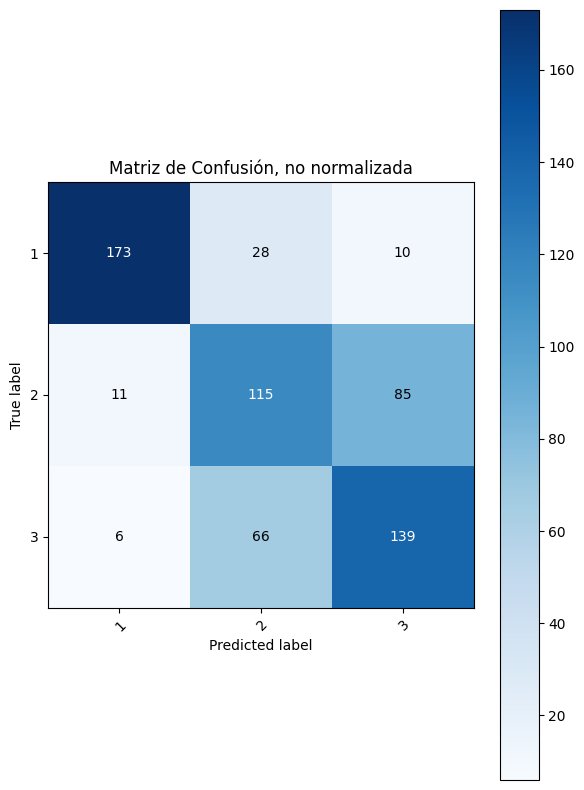

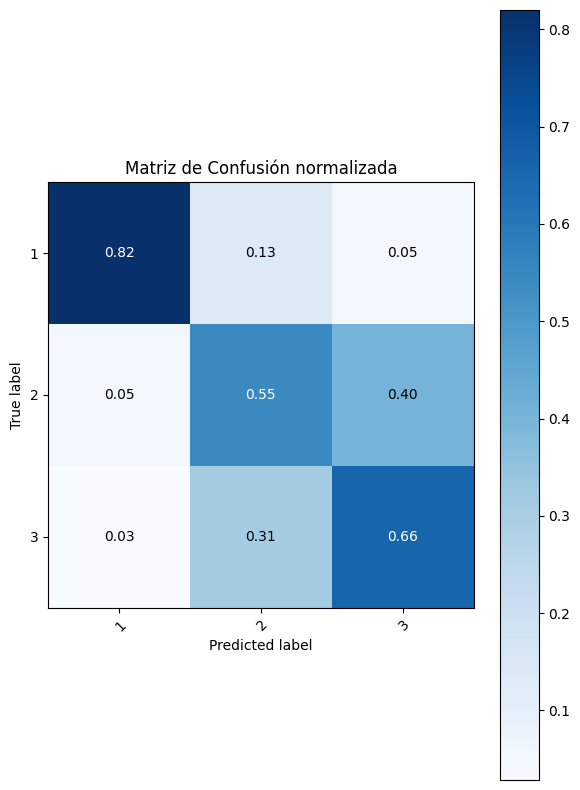

In [ ]:
# Crear y entrenar el modelo LGBMClassifier
model_lgbm = lgb.LGBMClassifier(force_col_wise=True)
model_lgbm.fit(X_train, y_train)

# Hacer predicciones
y_test, pred_val = evaluar_modelo(model_lgbm)

guardar_predicciones_como_csv(y_test,'LGBM_CMA.csv')

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)


## **LGBM con Cross Validation**

In [ ]:
cv = KFold(n_splits = 8, shuffle = False)
cv_f1scores=[]

for cv_train, cv_test in cv.split(X_train):

  cv_train_x = X_train.iloc[cv_train]
  cv_train_y = y_train.iloc[cv_train]


  model_lgbm.fit(cv_train_x, cv_train_y)


  y_pred = model_lgbm.predict(X_train.iloc[cv_test])

  y_np=y_train.iloc[cv_test].values

  cv_f1score = metrics.f1_score( y_np,y_pred, average='micro')

  cv_f1scores.append(cv_f1score)

media_scores=sum(cv_f1scores)/len(cv_f1scores)


print ("F1_Score medio: = %.4f" %  (media_scores ))

[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 22
[LightGBM] [Info] Start training from score -1.090611
[LightGBM] [Info] Start training from score -1.100220
[LightGBM] [Info] Start training from score -1.105060
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 22
[LightGBM] [Info] Start training from score -1.090611
[LightGBM] [Info] Start training from score -1.111753
[LightGBM] [Info] Start training from score -1.093604
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 22
[LightGBM] [Info] Start training from score -1.109923
[LightGBM] [Info] Start training from score -1.084651
[LightGBM] [Info] Start training from score -1.101428
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 4980, number of used features: 22
[LightGBM] [Info] 

              precision    recall  f1-score   support

         1.0       0.83      0.91      0.87       194
         2.0       0.50      0.57      0.53       186
         3.0       0.69      0.57      0.63       253

    accuracy                           0.67       633
   macro avg       0.67      0.68      0.68       633
weighted avg       0.68      0.67      0.67       633

Accuracy en validation: 0.674565560821485
F1_score en validation: 0.674565560821485


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[176  21  14]
 [ 11 106  94]
 [  7  59 145]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.83412322 0.09952607 0.06635071]
 [0.0521327  0.50236967 0.44549763]
 [0.03317536 0.27962085 0.68720379]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

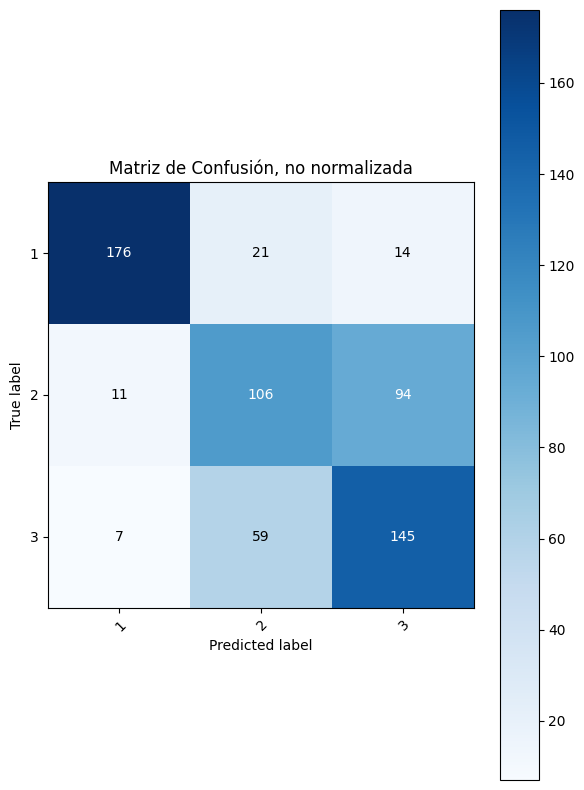

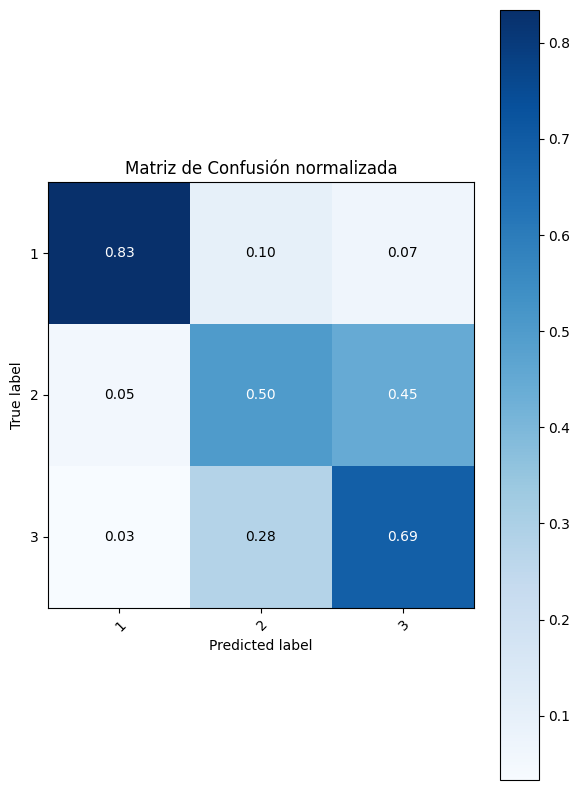

In [ ]:
# Hacer predicciones
y_test, pred_val = evaluar_modelo(model_lgbm)

guardar_predicciones_como_csv(y_test,'LGBM_CV.csv')

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

## **LGBM con GridSearch**

In [ ]:
parametros = {
    'num_leaves'      : [100,200],
    'min_data_in_leaf': [500,1000],
    'max_depth'       : [4,8],
    'num_threads'     : [2,4]
}

# Cross Validation
cv = KFold(n_splits=8, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# GridSearch
GS_lgbm = GridSearchCV(model_lgbm, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
GS_lgbm.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = GS_lgbm.best_params_
print(mejores_params)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [ ]:
#evaluar y subir fichero
model_lgbm_gs = lgb.LGBMClassifier(force_col_wise=True,**mejores_params)
model_lgbm_gs.fit(X_train , y_train)

# Evaluar modelo y descargar fichero
y_test,pred_val = evaluar_modelo(model_lgbm_gs)


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [ ]:
guardar_predicciones_como_csv(y_test,'LGBM_GS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[177  26   8]
 [ 10 100 101]
 [  5  68 138]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.83886256 0.12322275 0.03791469]
 [0.04739336 0.47393365 0.47867299]
 [0.02369668 0.32227488 0.65402844]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

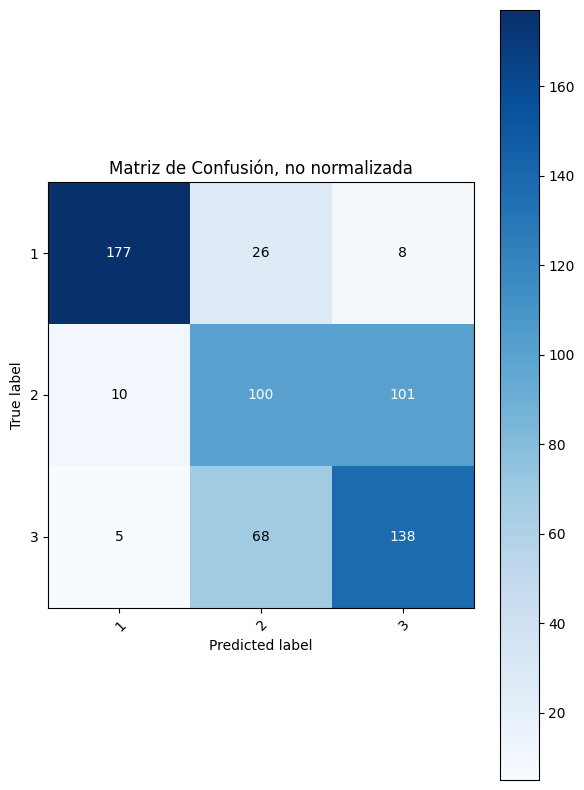

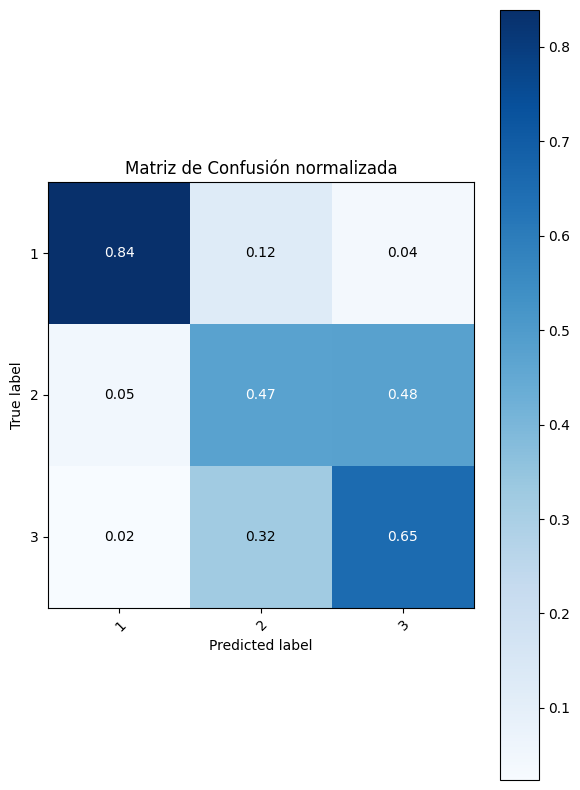

In [ ]:
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)

## LGBM con RandomSearch

In [ ]:
parametros = {
    'num_leaves'      : [10,100,200],
    'min_data_in_leaf': [500,1000,2000],
    'max_depth'       : [4,6,8],
    'num_threads'     : [2,4,8]
}

# Cross Validation
cv = KFold(n_splits=8, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# Random Search
RS_lgbm = RandomizedSearchCV(model_lgbm, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
RS_lgbm.fit(X_train, y_train)

# Obtener mejores parámetros
mejores_params = RS_lgbm.best_params_
print(mejores_params)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [ ]:
mejores_params={'num_threads': 2, 'num_leaves': 100, 'min_data_in_leaf': 500, 'max_depth': 8}
model_lgbm_rs = lgb.LGBMClassifier(force_col_wise=True,**mejores_params)
model_lgbm_rs.fit(X_train , y_train)
preds_val = model_lgbm_rs.predict(X_val)
print('F1_score del modelo en validation:',metrics.f1_score( y_val,preds_val, average='micro'))

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [ ]:
# Hacer predicciones
y_test, y_pred = evaluar_modelo(model_lgbm_rs)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
              precision    recall  f1-score   support

         1.0       0.84      0.91      0.87       196
         2.0       0.46      0.53      0.49       186
         3.0       0.66      0.56      0.61       251

    accuracy                           0.66       633
   macro avg       0.66      0.66      0.66       633
weighted avg       0.66      0.66      0.66       633

Accuracy en validation: 0.6571879936808847
F1_score en validation: 0.6571879936808847


In [ ]:
guardar_predicciones_como_csv(y_test,'LGBM_RS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión, no normalizada
[[177  26   8]
 [ 10 100 101]
 [  5  68 138]]
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Matriz de Confusión normalizada
[[0.83886256 0.12322275 0.03791469]
 [0.04739336 0.47393365 0.47867299]
 [0.02369668 0.32227488 0.65402844]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

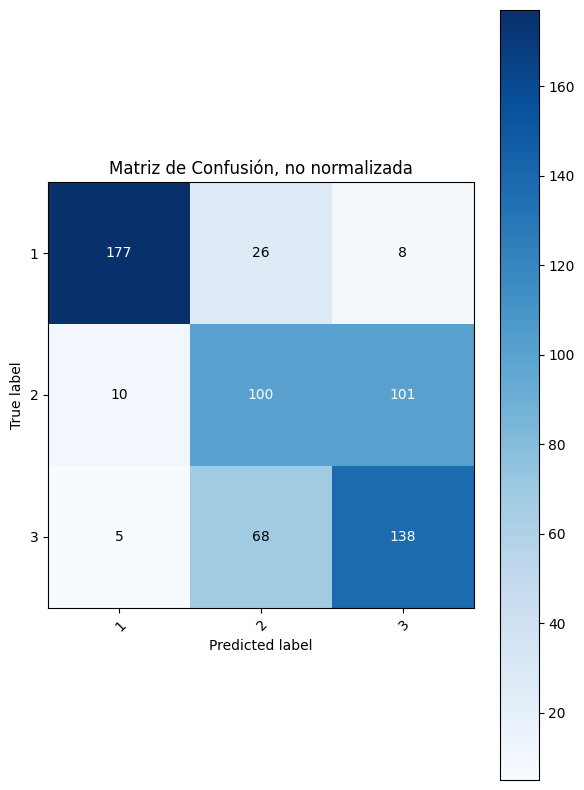

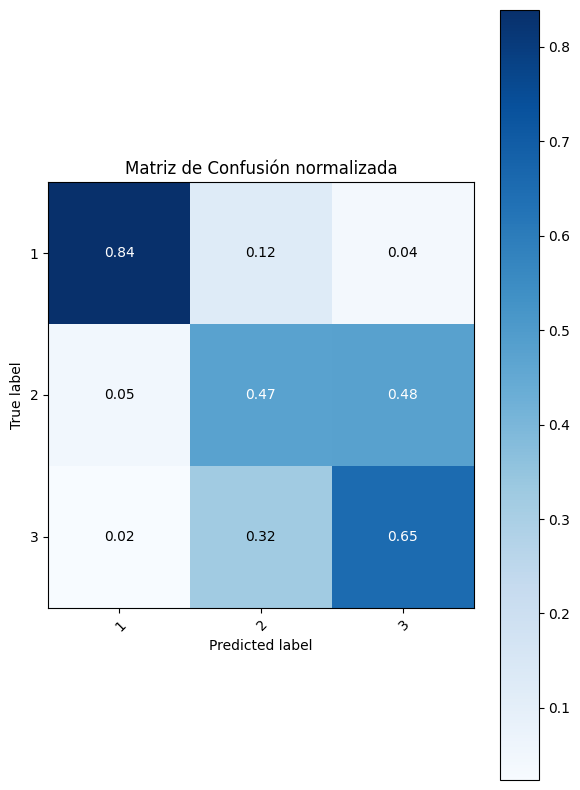

In [ ]:
# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_val, pred_val)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=False)
plot_confusion_matrix(y_val, pred_val, classes= np.array(['0','1','2','3']) , normalize=True)